<style>
div.text_cell_render {
font-size: 12pt;
}
</style>

Note: This tutorial is an [IPython notebook](http://ipython.org/notebook.html)
which is a web-based interactive environment where code, text and plots can be
combined and the code snippets can be executed (and modified) directly.
IPython can be installed on Linux, Mac and Windows - please follow the
instructions on [http://ipython.org/install.html](http://ipython.org/install.html).

Alternatively, we provide the tutorial as an HTML and PDF file.


# Tutorial for TDT Competition 2014 - [Challenge 1](http://www.tdtproject.org/challenge-1---malaria-hts.html)
## Anti-Malaria Hit Finding Using Classifier-Fusion Boosted Predictive Models

*Sereina Riniker and Gregory Landrum*

*Novartis Institutes for BioMedical Research, Basel, Switzerland*

In this tutorial, we will learn to:

* analyse the hit list from a [high-throughput screen](http://en.wikipedia.org/wiki/High-throughput_screening) (HTS) in order to select compounds for a confirmation assay
* build and validate a predictive model using the HTS data
* use the model in ligand-based [virtual screening](http://en.wikipedia.org/wiki/Virtual_screening) (VS) of a set of commercially available molecules.

The whole-cell phenotypic screen investigated here is against [<i>Plasmodium falciparum</i>](http://en.wikipedia.org/wiki/Plasmodium_falciparum) (Pf), a protozoan parasite that causes [Malaria](http://en.wikipedia.org/wiki/Malaria) in humans. Such screening campaigns have been successful in the past in identifying new chemotypes ([<i>Chem. Biol.</i> (2012), <b>19</b>, 116](http://www.sciencedirect.com/science/article/pii/S1074552112000178)).

The analysis of the HTS data will be done by a standard hit-list triaging workflow: filtering the primary hits for drug-like properties, removing compounds with potentially problematic substructures, and clustering by chemical series. Based on this, a subset of hits is proposed for validation in confirmation assays.

For the predictive model in step 2, we will investigate a set of [machine-learning](http://en.wikipedia.org/wiki/Machine_learning) (ML) methods and combine the most promising models by heterogeneous classifier fusion  in order to take advantage of the individual strengths of the different ML methodologies.

Finally in step 3, the fusion model is used to rank-order a set of untested commercially available molecules (list obtained from [eMolecules](http://www.emolecules.com/)) based on the predicted probability to be active. This list is further processed to identify an interesting subset for follow-up screening.

#### Software

The workflow consists of this tutorial together with a series of [Python](http://www.python.org/) scripts for the computationally more demanding tasks which can be run in a shell or on a cluster. The Python libraries used during this tutorial are all open-source and freely downloadable from the web. These are the cheminformatics toolkit [RDKit](http://www.rdkit.org), the machine-learning toolkit [scikit-learn](http://scikit-learn.org), [pandas](http://pandas.pydata.org/) for working data tables, and libraries for scientific computing, [numpy](http://www.numpy.org) and [scipy](http://scipy.org/scipylib/index.html). 

Tutorials for many of the tools used are available online:

- [Python](http://docs.python.org/2/tutorial/)
- [SciPy](http://www.scipy.org/getting-started.html)
- [scikit-learn](http://scikit-learn.org/stable/tutorial/)
- [pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
- [RDKit](http://rdkit.org/docs/GettingStartedInPython.html)

Additionally, the book [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) is an excellent resource for getting started with many of the tools used here.

RDKit version 2013.09, scikit-learn version 0.13, numpy version 1.6.2 and scipy version 0.9.0 were used when developing this tutorial. Figures are plotted using [matplotlib](http://matplotlib.org/) version 1.1.0.

## Task 1: Analysis of Primary HTS Data

The hit list of an HTS screen can contain artifacts that lead to false positives. Artifacts can be due to the chemical structure (i.e. reactive, toxic, interfering in assay signaling, etc.), the assay, screening technology and storage conditions ([<i>Curr. Opin. Chem. Biol.</i> (2006), <b>10</b>, 343](http://www.sciencedirect.com/science/article/pii/S136759310600086X)). Testing these in a subsequent confirmatory assay would cost time and resources and may mislead the medicial chemists. Therefore, a triaging step is usually performed on the hit-list to remove as many potential false positives as possible. For this, we will use both property filters (e.g. molecular weight) as well as problematic-substructure filters (e.g. rhodanines).

We will use the following property filters for <i>in silico</i> post-processing which are a combination of the filters from the Rapid Elimination of Swill (REOS) described in [<i>Nature Rev.</i> (2003), <b>2</b>, 259](http://www.nature.com/nrd/journal/v2/n4/abs/nrd1063.html) and the ones described in [<i>Curr. Opin. Chem. Biol.</i> (2006), <b>10</b>, 343](http://www.sciencedirect.com/science/article/pii/S136759310600086X). We choose softer filters than in REOS because we do not have an experienced medicinal chemist at hand who can look through the discarded molecules and "rescue" interesting compounds.

* Molecular weight: 100-700 g/mol
* Number of heavy atoms: 5-50
* Number of rotatable bonds: 0-12
* Hydrogen-bond donors: 0-5
* Hydrogen-bond acceptors: 0-10
* Hydrophobicity: -5 < logP < 7.5

To remove compounds with potentially problematic substructures, we will use the PAINS (Pan Assay Interference Compounds) filters described in [<i>J. Med. Chem.</i> (2010), <b>53</b>, 2719](http://pubs.acs.org/doi/abs/10.1021/jm901137j).

After we have filtered the primary hits, we will have a look at the chemical series in the set. There may be a large number of compounds sharing the same scaffolds/chemotypes; we do not necessarily want to test all of these in a confirmatory assay. We want to strike a good balance between gaining [structure-activity relationship (SAR)](http://en.wikipedia.org/wiki/Structure-activity_relationship) information from molecules with the same chemotype and testing as many diverse chemotypes as possible. For this, we will cluster the compounds and sample from these clusters.

#### Primary HTS Data

The data from the primary phenotypic screen is provided by the TDT challenge in the file <i>malariahts_trainingset.txt</i> which we downloaded from the [TDT website](http://www.tdtproject.org/challenge-1---malaria-hts.html), [gzipped](http://docs.python.org/3.3/library/gzip.html) and saved in the directory <i>data</i>. 

The file contains six columns: 

- SAMPLE: ID of the compound
- Pf3D7_ps_green: intensity from green fluorescence readout
- Pf3D7_ps_red: intensity from red fluorescence readout
- Pf3D7_ps_hit: activity outcome (true, false, or ambiguous)
- Pf3D7_pEC50: measured log([EC50](http://en.wikipedia.org/wiki/EC50)) value from a [dose-response](http://en.wikipedia.org/wiki/Dose-response) confirmation assay (if tested, else "NA")
- canonical SMILES

Normally, the first step would be to classify the compounds (i.e. select hits) based on their activity value using an analytic method such as Z-scores (for a discussion see [<i>J. Biomol. Screen.</i> (2011), <b>16</b>, 775](http://jbx.sagepub.com/content/16/7/775.abstract)). Here, an activity outcome (true, false, ambiguous) is already provided and we will use this classification in the following.

We start by separating the actives (activity outcome = true) and the inactives (activity outcome = false) in two different files. The molecules with an ambiguous outcome we will ignore. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gzip
actives = []
inactives = []
ambiguous = 0
for line in gzip.open('data/malariahts_trainingset.txt.gz', 'r'):
    if line[0] == "#": continue
    line = line.strip().split()
    # contains: [sample_id, value_green, value_red, hit, pec50, smiles]
    if line[3] == 'true': # = actives
        # store: [sample_id, hit, pec50, smiles]
        actives.append((line[0], line[3], line[4], line[5]))
    elif line[3] == 'false': # = inactives
        inactives.append((line[0], line[3], line[4], line[5]))
    else: # ambiguous --> ignore
        ambiguous += 1
num_actives = len(actives)
num_inactives = len(inactives)
print "number of actives =", num_actives
print "number of inactives =", num_inactives
print "number of ambiguous molecules =", ambiguous

# write the actives
outfile = gzip.open('data/training_actives.dat.gz', 'w')
outfile.writelines("%s\n" % ("\t".join(a[:4])) for a in actives)
outfile.close()
# and the inactives
outfile = gzip.open('data/training_inactives.dat.gz', 'w')
outfile.writelines("%s\n" % ("\t".join(a[:4])) for a in inactives)
outfile.close()

number of actives = 1528
number of inactives = 293608
number of ambiguous molecules = 10432


As we will use RDKit for the handling of molecules, we check if the given canonical [SMILES](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) can be converted to an [RDKit molecule](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdchem.Mol-class.html).

In [3]:
from rdkit import Chem
# check the SMILES of the actives
count = 0
outfile = gzip.open('data/training_actives_cleaned.dat.gz', 'w')
for line in gzip.open('data/training_actives.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    if m is not None:
        outfile.write("%s\n" % ("\t".join(line[:4])))
    else:
        count += 1
outfile.close()
num_actives -= count # decrease the number of actives accordingly
print "number of actives with RDKit-invalid SMILES =", count

number of actives with RDKit-invalid SMILES = 0


In [4]:
# check the SMILES of the inactives
count = 0
outfile = gzip.open('data/training_inactives_cleaned.dat.gz', 'w')
for line in gzip.open('data/training_inactives.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    if m is not None:
        outfile.write("%s\n" % ("\t".join(line[:4])))
    else:
        count += 1
outfile.close()
num_inactives -= count # decrease the number of inactives accordingly
print "number of inactives with RDKit-invalid SMILES =", count

number of inactives with RDKit-invalid SMILES = 2


#### Property Filters

We start by reading the SMILES of the actives and generate molecules for them.

In [5]:
mols = []
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    mols.append((m, line[0]))
print "number of actives =", len(mols)

number of actives = 1528


Next, we calculate the molecular weight of each compound and take only those between 100 - 700 g/mol. Molecules with high molecular weight have often a low membrane permeability.

In [6]:
from rdkit.Chem import Descriptors
# loop over molecules
new_mols = []
bad_mols = []
for m,idx in mols:
    mw = Descriptors.MolWt(m)
    if mw > 700 or mw < 100: 
        bad_mols.append((m, idx))
    else:
        new_mols.append((m, idx))
mols = new_mols
print "number of actives with 100 < MW < 700 =", len(mols) 

number of actives with 100 < MW < 700 = 1527


Let's have a look at the molecule that was discarded.

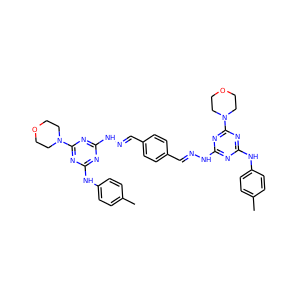

In [7]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
Draw.MolToImage(bad_mols[0][0])

Next, we check that the number of heavy atoms is between 5 and 50, and that the number of rotatable bonds is less than 12 (this number is higher than the filter used in REOS because RDKit has the tendency to overcount rotatable bonds).

In [8]:
from rdkit.Chem import AllChem
# loop over molecules
new_mols = []
bad_mols = []
for m,idx in mols:
    num_ha = m.GetNumHeavyAtoms()
    num_rb = AllChem.CalcNumRotatableBonds(m)
    if num_ha > 50 or num_ha < 5 or num_rb > 12: 
        bad_mols.append((m, idx))
    else:
        new_mols.append((m, idx))
mols = new_mols
print "number of actives with 5-50 heavy atoms and < 12 \
rotatable bonds = %i" % len(mols) 

number of actives with 5-50 heavy atoms and < 12 rotatable bonds = 1521


The molecules discarded at this step are below, most of them contain long aliphatic chains:

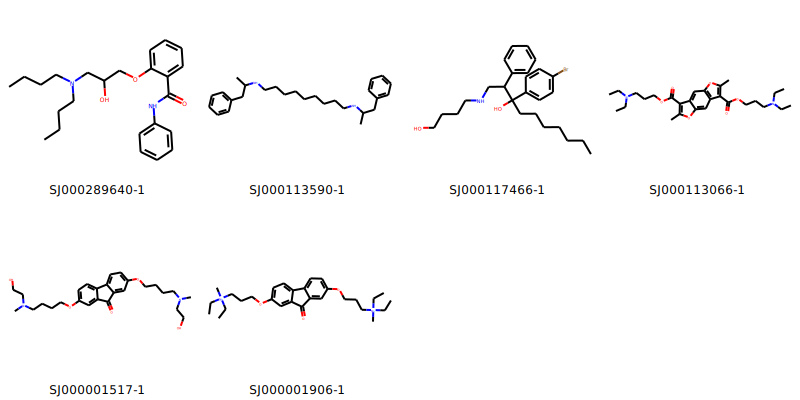

In [9]:
Draw.MolsToGridImage([m[0] for m in bad_mols], 
                     legends=[m[1] for m in bad_mols], 
                     molsPerRow=4)

Now, we check the number of hydrogen-bond donors and acceptors. A large number of hydrogen bond donors and/or acceptors can lead to low membrane permeability.

In [10]:
# loop over molecules
new_mols = []
bad_mols = []
for m,idx in mols:
    num_hba = AllChem.CalcNumHBA(m) # acceptors
    num_hbd = AllChem.CalcNumHBD(m) # donors
    if num_hba > 10 or num_hbd > 5: 
        bad_mols.append((m, idx))
    else:
        new_mols.append((m, idx))
mols = new_mols
print "number of actives with < 5 H-bond donors and < 10 \
H-bond acceptors = %i" % len(mols) 

number of actives with < 5 H-bond donors and < 10 H-bond acceptors = 1521


Here, all molecules pass our filter.

The last property filter is to check the [partition coefficient](http://en.wikipedia.org/wiki/Partition_coefficient) logP of the compounds which is a measure of lipophilicity. For this, we calculate the logP value based on atom contributions as described in [<i>J. Chem. Inf. Comput. Sci</i> (1999), <b>39</b>, 868](http://pubs.acs.org/doi/abs/10.1021/ci990307l).

In [11]:
from rdkit.Chem import Crippen
new_mols = []
bad_mols = []
for m,idx in mols:
    logp = Crippen.MolLogP(m)
    if logp < -5 or logp > 7.5:
        bad_mols.append((m, idx))
    else:
        new_mols.append((m, idx))
mols = new_mols
print "number of actives with -5 < logP < 7.5 = %i" % len(mols) 

number of actives with -5 < logP < 7.5 = 1519


The molecules discarded at this step are:

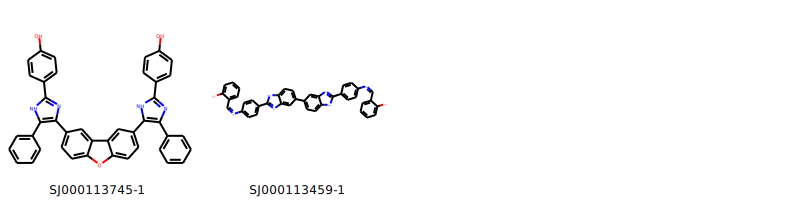

In [12]:
Draw.MolsToGridImage([m[0] for m in bad_mols], 
                     legends=[m[1] for m in bad_mols], 
                     molsPerRow=4)

#### Problematic Substructure Filtering

The PAINS filters described in [<i>J. Med. Chem.</i> (2010), <b>53</b>, 2719](http://pubs.acs.org/doi/abs/10.1021/jm901137j) were converted to [SMARTS](http://en.wikipedia.org/wiki/Smiles_arbitrary_target_specification) patterns by [Macs in Chemistry](http://www.macinchem.org/reviews/pains/painsFilter.php). There are four files in the directory <i>pains_filters</i>: one file for each of the three families described in the original publication plus one file containing all filters (<i>PAINS.sieve</i>). The files have five columns: FRAGMENT, name, SMARTS, minimum, maximum. Minimum and maximum define how often a specific fragment is allowed to occur in a molecule. However, for the patterns in <i>PAINS.sieve</i> the maximum value is always zero, therefore we can ignore this information.

In [13]:
pains = []
for line in open('pains_filter/PAINS.sieve', 'r'):
    if line[0] == "#": continue # ignore header
    line = line.strip().split()
    if line:
        m = Chem.MolFromSmarts(line[2])
        pains.append(m)
print "number of PAINS SMARTS patterns =", len(pains)

number of PAINS SMARTS patterns = 481


Now, we loop over the property-filtered compounds and discard any that have a substructure match with one of the PAINS.

In [14]:
new_mols = []
bad_mols = []
for m,idx in mols:
    match = False
    for patt in pains:
        if m.HasSubstructMatch(patt):
            match = True
            break # there is a match, stop searching
    if not match:
        new_mols.append((m, idx))
    else:
        bad_mols.append((m, idx))
mols = new_mols
print "number of actives without problematic \
substructures = %i" % len(mols) 

number of actives without problematic substructures = 1232


Some of the molecules with problematic substructures are:

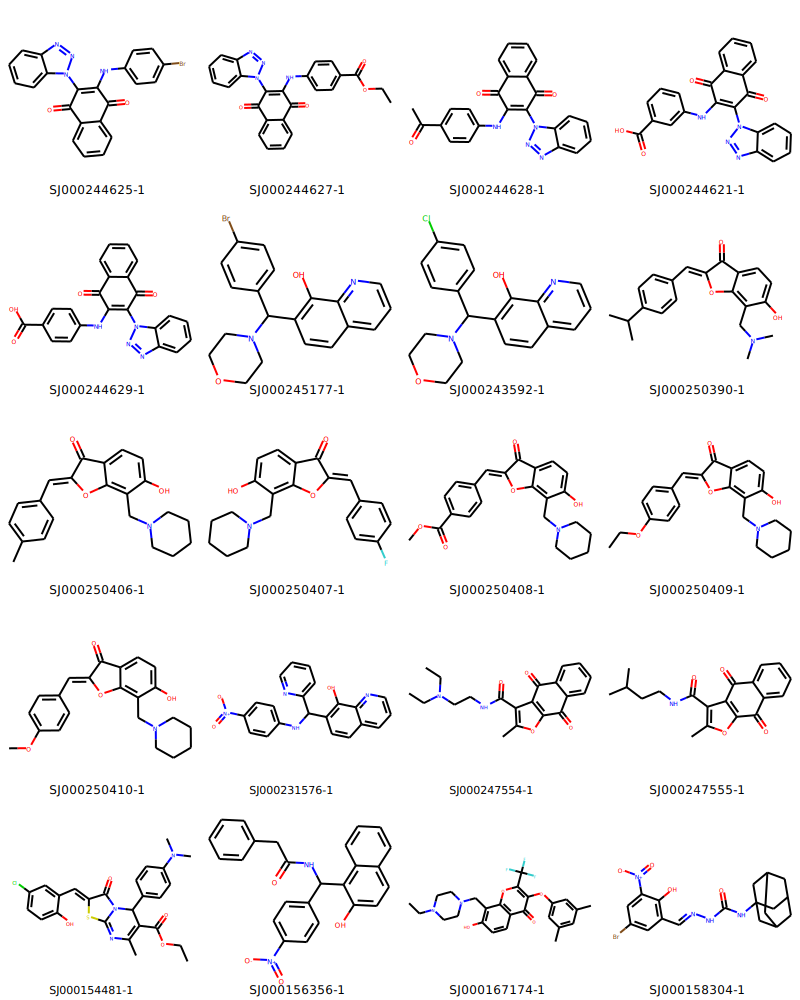

In [15]:
Draw.MolsToGridImage([m[0] for m in bad_mols[:20]], 
                     legends=[m[1] for m in bad_mols[:20]], 
                     molsPerRow=4)

At this point, normally a medicial chemist would get involved, look at the discarded molecules and "rescue" interesting looking ones. This is of course not possible for the tutorial, therefore we will discard all of them.

#### Comparison to EC50 Data

Here, we are in the fortunate position to have already data from a confirmatory screen available. So, let's compare how many of the filtered molecules were actually tested in the confirmatory screen and how many of the tested ones were true positives. 

First, we get the sample IDs of the molecules with a measured pEC50 value.

In [16]:
pEC50 = {}
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    if line[2] != 'NA':
        pEC50[line[0]] = float(line[2])
print "number of compounds with pEC50 value =", len(pEC50)

number of compounds with pEC50 value = 1189


To decide what cutoff to use for active/inactive classification we have to look at the distribution of pEC50 values. For an easy target, a cutoff of EC50 < 10 uM might be too high and we have too many actives, whereas for a difficult target such a cutoff is too low and we find hardly any actives.

percent molecules < 10 uM: 75.11 %
percent molecules < 1 uM: 21.78 %


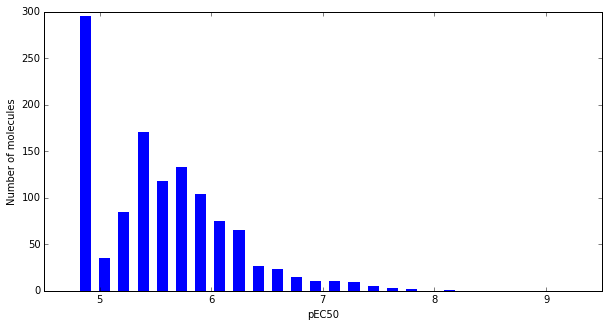

In [17]:
import numpy
pec_hist = numpy.histogram([pEC50.values()], bins=20)
num_pec = float(len(pEC50.keys()))
p_gt5 = len([p for p in pEC50.values() if p > 5]) / num_pec * 100
p_gt6 = len([p for p in pEC50.values() if p > 6]) / num_pec * 100
print "percent molecules < 10 uM: %.2f %%" % p_gt5
print "percent molecules < 1 uM: %.2f %%" % p_gt6
# plot it
fig = plt.figure(1, figsize=(10, 5))
plt1 = plt.subplot(111)
plt.axis([4.5, 9.5, 0, 300])
plt.xlabel('pEC50')
plt.ylabel('Number of molecules')
plt1.bar(pec_hist[1][:-1], pec_hist[0], lw=0, width=0.1)
plt.show()

The distribution indicates the target is rather easy with 75% actives at a cutoff of 10 uM. We therefore set the cutoff for (strong) actives to EC50 < 1 uM (i.e. pEC50 > 6.0), but treat the molecules with 1 uM < EC50 < 10 uM as weak actives.

In [18]:
not_measured = 0
positive = 0
medium = 0
negative = 0
for m,idx in mols:
    if pEC50.has_key(idx):
        if pEC50[idx] > 6.0: # 1uM
            positive += 1
        elif pEC50[idx] > 5.0: # 10 uM
            medium += 1
        else:
            negative += 1
    else:
        not_measured += 1
print "number of not measured compounds = %i" % not_measured
print "EC50 < 1 uM:\t%i molecules" % positive
print "1 uM < EC50 < 10 uM:\t%i molecules" % medium
print "EC50 > 10 uM:\t%i molecules" % negative

number of not measured compounds = 310
EC50 < 1 uM:	187 molecules
1 uM < EC50 < 10 uM:	482 molecules
EC50 > 10 uM:	253 molecules


How many of the molecules that did not pass our triaging filters were actually tested in the confirmatory screen?

In [19]:
measured_idx = set(pEC50.keys())
proposed_idx = set([idx for m,idx in mols])
notproposed_idx = measured_idx.difference(proposed_idx)
notproposed_pos = 0
notproposed_med = 0
notproposed_neg = 0
for k in notproposed_idx:
    if pEC50[k] > 6.0: notproposed_pos += 1
    elif pEC50[k] > 5.0: notproposed_med += 1
    else: notproposed_neg += 1
print "molecules with EC50 < 1 uM:\t%i" % notproposed_pos
print "molecules with 1 uM < EC50 < 10 uM:\t%i" % notproposed_med
print "molecules with EC50 > 10 uM:\t%i" % notproposed_neg

molecules with EC50 < 1 uM:	72
molecules with 1 uM < EC50 < 10 uM:	152
molecules with EC50 > 10 uM:	43


Do these 267 compounds not in our filtered selection but tested in the confirmatory screen contain any PAINS patterns?

In [20]:
notproposed_mols = []
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    if line[0] in notproposed_idx:
        notproposed_mols.append((Chem.MolFromSmiles(line[3]), line[0]))
print "number of not proposed molecules = %i" % len(notproposed_mols)

number of not proposed molecules = 267


In [21]:
bad_mols = []
for m,idx in notproposed_mols:
    match = False
    for patt in pains:
        if m.HasSubstructMatch(patt):
            match = True
            break # there is a match, stop searching
    if match:
        bad_mols.append((m, idx))
print "number of molecules with problematic \
substructures = %i" % len(bad_mols) 

number of molecules with problematic substructures = 259


So, 259 out of the 269 molecules contain problematic substructures and were therefore not in our selection. Even if many of them were tested active in the confirmatory screen (i.e. EC50 < 1 uM), they may be toxic or have other unwanted properties.

This was just a quick informational exercise. In a normal setting, we would not already have EC50 data as we are picking compounds for a confirmatory assay.

#### Clustering Based on Similarity

The property and substructure filters we have applied still leave us with many more measured actives than we could submit for a confirmatory screen; we need to pick a subset. In order to obtain as much information as possible from the confirmatory screen, we would like to pick a few members of each chemical series in our set. Since there is no standard computational approach to identify chemical series, we'll use a surrogate and cluster the compounds based on chemical similarity.

For this exercise, we will use the RDK5 fingerprint (a subgraph-based fingerprint similar to the well-known [Daylight fingerprint](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)) and the [Butina clustering algorithm](http://pubs.acs.org/doi/abs/10.1021/ci9803381). The similarity between two fingerprints is calculated using the [Tanimoto coefficient](http://en.wikipedia.org/wiki/Tanimoto_coefficient#Tanimoto_coefficient_.28extended_Jaccard_coefficient.29), although other similarity metrics could be used as well ([<i>J. Chem. Inf. Model.</i> (2012), <b>52</b>, 2884](http://pubs.acs.org/doi/abs/10.1021/ci300261r)). We take a cutoff = 0.5 for the distance, i.e. all molecules in a cluster have a maximum distance of 0.5 from the cluster center. 

In [25]:
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
# calculate fingerprints
fps = []
for m,idx in mols:
    fps.append(Chem.RDKFingerprint(m, maxPath=5))
# generate distance matrix
dist_matrix = []
num_fps = len(fps)
for i in range(1, num_fps):
    similarities = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
    dist_matrix.extend([1-x for x in similarities])
# cluster
clusters = Butina.ClusterData(dist_matrix, num_fps, 0.5, isDistData=True) # distance cutoff = 0.5
print "number of clusters =", len(clusters)
num_clust_g5 = len([c for c in clusters if len(c) > 5])
print "number of clusters with more than 5 compounds =", num_clust_g5

number of clusters = 305
number of clusters with more than 5 compounds = 40


The size of the clusters is distributed as follows (for the first half of the clusters).

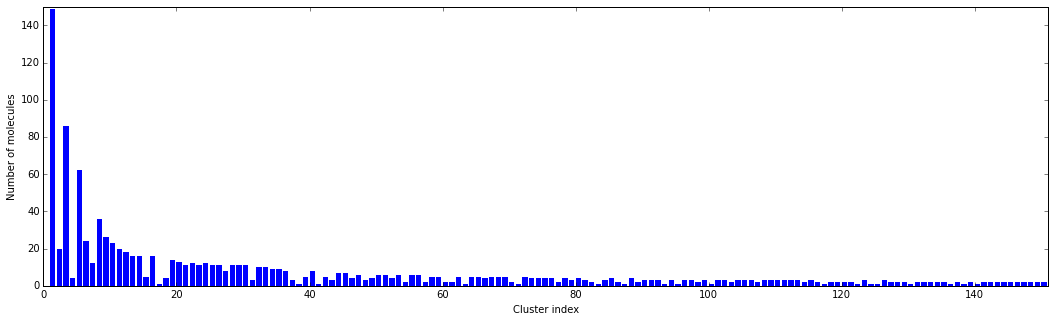

In [26]:
# plot the size of the first 150 clusters
fig = plt.figure(1, figsize=(18, 5))
plt1 = plt.subplot(111)
plt.axis([0, 151, 0, len(clusters[0])+1])
plt.xlabel('Cluster index')
plt.ylabel('Number of molecules')
plt1.bar(range(1, 151), [len(c) for c in clusters[:150]], lw=0)
plt.show()

Let's have a look at the first twelve molecules in the largest cluster.

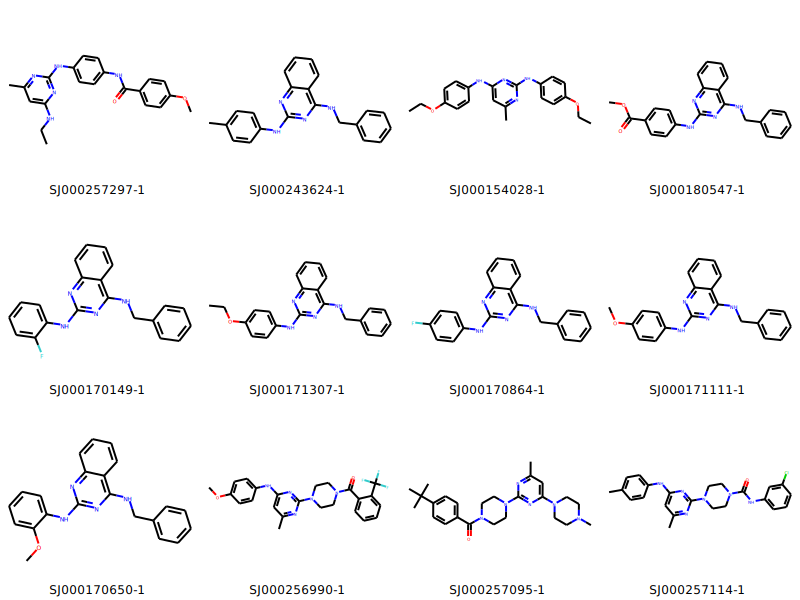

In [27]:
Draw.MolsToGridImage([mols[i][0] for i in clusters[0][:12]], 
                     legends=[mols[i][1] for i in clusters[0][:12]], 
                     molsPerRow=4)

The molecules in the cluster look indeed similar to each other and many share a common scaffold. The scaffold can be obtained by calculating the maximum common substructure (MCS) of all molecules in the cluster. We set the threshold to 0.8, i.e. the MCS has to be present in 80% of the molecules. This allows to retrieve the "real" scaffold even when one or two of the molecules have a slightly different one.

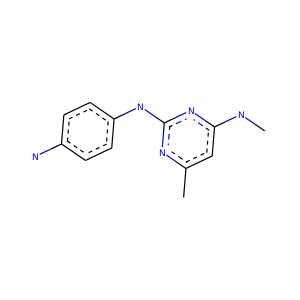

In [28]:
from rdkit.Chem import MCS
mcs = MCS.FindMCS([mols[i][0] for i in clusters[0]], threshold=0.8)
m = Chem.MolFromSmarts(mcs.smarts)
Draw.MolToImage(m)

#### Compound Selection

For the final list of 500 compounds which we propose for testing in a confirmatory assay, we take from each cluster the cluster centre (i.e. the first molecule) and then we take - starting with the largest cluster - for each cluster the 5 molecules (or 50% if less than 5 molecules are left in the cluster) most similar to the cluster center, until we have selected 500 compounds.

The idea behind this approach is to ensure diversity (because we have respresentatives of each cluster) and the chance of getting some SAR from the results of the confirmatory assay (because we have groups of quite similar molecules).

In [29]:
# take the cluster centre of each cluster
final_mols = [mols[c[0]] for c in clusters]

# sort the molecules within a cluster based on their similarity 
# to the cluster centre and sort the clusters based on their size
clusters2 = []
for c in clusters:
    if len(c) < 2: continue
    fps_clust = [Chem.RDKFingerprint(mols[i][0], maxPath=5) for i in c]
    simils = DataStructs.BulkTanimotoSimilarity(fps_clust[0], 
                                                fps_clust[1:])
    simils = [(s,i) for s,i in zip(simils, c[1:])]
    simils.sort(reverse=True)
    clusters2.append((len(simils), [i for s,i in simils]))
clusters2.sort(reverse=True)

# take 5 molecules (or 50%) of each cluster starting with the 
# largest one
idx = 0
diff = 500 - len(final_mols)
while diff > 0:
    c = clusters2[idx][1]
    if clusters2[idx][0] > 5:
        num_cmps = 5
    else:
        num_cmps = int(0.5*len(c))+1
    if num_cmps > diff: num_cmps = diff
    final_mols += [mols[i] for i in c[:num_cmps]]
    idx += 1
    diff = 500 - len(final_mols)
print "number of selected molecules =", len(final_mols)

number of selected molecules = 500


The molecules picked from the largest cluster are shown below (aligned by the scaffold), where the first one is the cluster center.

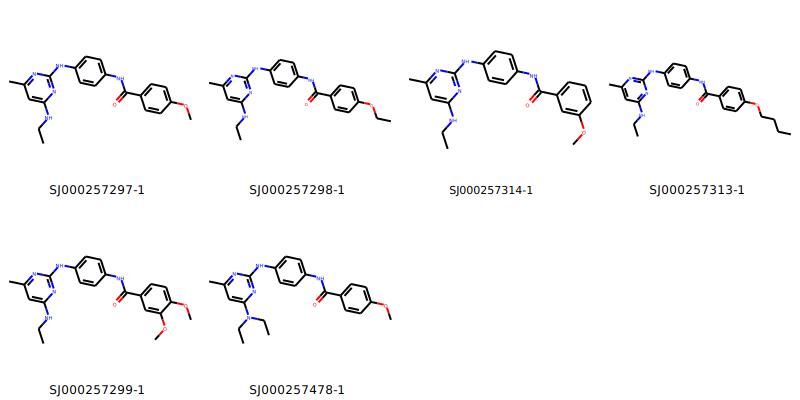

In [30]:
num_clust = len(clusters)
mols_cluster0 = [final_mols[0]] + final_mols[num_clust:num_clust+5]
mcs = MCS.FindMCS([m[0] for m in mols_cluster0]) # get scaffold
scaffold = Chem.MolFromSmarts(mcs.smarts)
AllChem.Compute2DCoords(scaffold) # generate 2D coordinates for scaffold
for m,idx in mols_cluster0: # align molecules to scaffold
    AllChem.GenerateDepictionMatching2DStructure(m, scaffold)
Draw.MolsToGridImage([m[0] for m in mols_cluster0], 
                     legends=[m[1] for m in mols_cluster0], 
                     molsPerRow=4)

From this six molecules, we will already be able to gain some SAR information. For example, the first and second molecule will show the effect between a methoxy and ethoxy group in para-position at the phenyl ring. Or the first and the last molecule will show the effect between a secondary amine (one ethyl substituent) or a tertiary amine (two ethyl substituents).

We write the compounds (identifier, SMILES) to a file in the directory <i>results</i>.

In [31]:
# write them to file
outfile = open('results/compounds_for_confirmatory_assay.txt', 'w')
outfile.write("#SAMPLE\tSMILES\n") # header
outfile.writelines("%s\t%s\r\n" % 
    (idx,Chem.MolToSmiles(m, isomericSmiles=True)) for m,i in final_mols)
outfile.close()

As a final point of curiosity: how many of the selected molecules were active in the confirmatory data provided as part of the TDT package?

In [32]:
not_measured = 0
positives = 0
medium = 0
negatives = 0
for m,idx in final_mols:
    if pEC50.has_key(idx):
        if pEC50[idx] > 6.0: # 1uM
            positives += 1
        elif pEC50[idx] > 5.0: # 10 uM
            medium += 1
        else:
            negatives += 1
    else:
        not_measured += 1
print "number of not measured compounds =", not_measured
print "EC50 < 1 uM:\t%i molecules" % positives
print "1 uM < EC50 < 10 uM:\t%i molecules" % medium
print "EC50 > 10 uM:\t%i molecules" % negatives

number of not measured compounds = 96
EC50 < 1 uM:	48 molecules
1 uM < EC50 < 10 uM:	230 molecules
EC50 > 10 uM:	126 molecules


## Task 2: Training and Evaluation of a Predictive Model

Using the actives and inactives from the phenotypic screen, we can train a machine-learning (ML) model. For the current purpose, we are interested in [<i>supervised</i> learning](http://en.wikipedia.org/wiki/Supervised_learning) methods. The [documentation of scikit-learn](http://scikit-learn.org/stable/user_guide.html) describes the different supervised techniques available from this library. In this tutorial, we focus on three methods: [random forest (RF)](http://en.wikipedia.org/wiki/Random_forest), [Naive Bayes (NB)](http://en.wikipedia.org/wiki/Naive_bayes) and [logistic regression (LR)](http://en.wikipedia.org/wiki/Logistic_regression), which we investigated in a recent study on ligand-based virtual screening (VS) ([<i>J. Chem. Inf. Model.</i> (2013), <b>53</b>, 2829](http://pubs.acs.org/doi/abs/10.1021/ci400466r)), and we will use the best (and most complementary) models for heterogeneous classifier fusion. To train the models, we test three different molecular fingerprints: atom pairs (AP), the RDKit fingerprint with a maximum path length = 5 (RDK5), and the circular fingerprint with radius = 2 (Morgan2) (for a description see [<i>J. Cheminf.</i> (2013), <b>5</b>, 26](http://www.jcheminf.com/content/5/1/26)).

Note: We will use all the information from the primary screen to train the predictive model, i.e. we do not apply any property or problematic-substructure filters. First of all, some of the filters may be too "hard" and we would discard valuable information, and secondly the ML methods used here are rather robust against noise (i.e. false positives and false negatives).

#### Selection of Test Set(s)

As the best combination of ML method and molecular fingerprint was found to be highly target-dependent, we need to evaluate the performance of different combinations in order to select the best (and most complementary) models for heterogeneous classifier fusion ([<i>J. Chem. Inf. Model.</i> (2013), <b>53</b>, 2829](http://pubs.acs.org/doi/abs/10.1021/ci400466r)). 

For the retrospective evaluation, we will randomly select 10% of the data and leave this out for testing. In addition, to reduce artifacts due to the random selection of the testing data, we will repeat this 50 times and calculate the average performance. We chose 50 as a compromise between getting good statistics and computational cost.

We start by [randomly](http://docs.python.org/2/library/random.html) selecting 10% of the molecules for testing, we repeat this 50 times. For this tutorial, we only need the indices of the molecules.

In [33]:
import random
# seed for random-number generator
random.seed(23)

# helper function
def selectAndWriteMols(outfile, mollist, num):
    random.shuffle(mollist)
    outfile.writelines("%i " % i for i in mollist[:num])
    outfile.write("\n")

percentage = 0.1 # = 10%
num_test_actives = int(percentage*num_actives)
num_test_inactives = int(percentage*num_inactives)
print "number of test actives = %i" %  num_test_actives
print "number of test inactives = %i" % num_test_inactives

# number of repetitions/test lists
num_lists = 50

# loop over the lists
outfile_act = gzip.open('test_lists/test_lists_\
10percent_actives.dat.gz', 'w')
outfile_inact = gzip.open('test_lists/test_lists_\
10percent_inactives.dat.gz', 'w')
for i in range(num_lists):
    # actives
    selectAndWriteMols(outfile_act, range(num_actives), 
                       num_test_actives)
    # inactives
    selectAndWriteMols(outfile_inact, range(num_inactives), 
                       num_test_inactives)
outfile_act.close()
outfile_inact.close()

number of test actives = 152
number of test inactives = 29360


#### Fingerprint Similarity

As we discussed in our [JCIM paper](http://pubs.acs.org/doi/abs/10.1021/ci400466r), when ranking molecules based on an ML model's predicted probability to be active, it is possible for multiple molecules to have the same probability. To break the tie, we make use of the maximum chemical similarity between the molecules and the training actives. The molecule which is more similar to the training actives gets ranked higher. To this end, we calculate for each molecule in the test sets the similarity to the actives in the training set and store the maximum value. This procedure is called MAX group fusion ([<i>QSAR Comb. Sci.</i> (2006), <b>25</b>, 1143](http://onlinelibrary.wiley.com/doi/10.1002/qsar.200610084/abstract)).

There is a Python script called <i>calculate\_similarity.py</i> in the directory <i>evaluation</i> to perform this task, which takes the fingerprint name as argument (i.e. rdk5, ap or morgan2). We will discuss here only the important steps of the script, whereas the complete script can be executed separately in a shell or be sent to a cluster for each fingerprint.

Firstly, the actives and inactives are read and the specified fingerprint is calculated for each molecule (e.g. RDK5).

In [33]:
# actives
fps_act = []
mols_act = []
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    fp = Chem.RDKFingerprint(m, maxPath=5) # max. path length = 5
    fps_act.append(fp)
    mols_act.append([line[0], m]) 
print "number of active fingerprints =", len(fps_act)

number of active fingerprints = 1528


In [34]:
# inactives
fps_inact = []
mols_inact = []
for line in gzip.open('data/training_inactives_cleaned.dat.gz', 'r'):
    line = line.strip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    fp = Chem.RDKFingerprint(m, maxPath=5) # max. path length = 5
    fps_inact.append(fp)
    mols_inact.append([line[0], m])
print "number of inactive fingerprints =", len(fps_inact)

number of inactive fingerprints = 293606


The first list of indices for the test molecules is read in and the corresponding molecules are selected. In addition, we collect for each molecule the information if it belongs to the actives (1) or inactives (0). This information is required for the evaluation later on.

In [35]:
# indices of actives
inlist = gzip.open('test_lists/test_lists_\
10percent_actives.dat.gz', 'r').readline()
test_indices_act = set(int(l) for l in inlist.strip().split())

# indices of inactives
inlist = gzip.open('test_lists/test_lists_\
10percent_inactives.dat.gz', 'r').readline()
test_indices_inact = set(int(l) for l in inlist.strip().split())
print "number of test actives = %i" % len(test_indices_act)
print "number of test inactives = %i" % len(test_indices_inact)

# test molecules: first the actives than the inactives
test_fps = [fps_act[i] for i in test_indices_act] \
+ [fps_inact[i] for i in test_indices_inact]

test_info = [1]*num_test_actives + [0]*num_test_inactives

test_mols = [mols_act[i] for i in test_indices_act] \
+ [mols_inact[i] for i in test_indices_inact]
print "number of total test molecules = %i" % len(test_fps)

number of test actives = 152
number of test inactives = 29360
number of total test molecules = 29512


The remaining actives are our training actives.

In [36]:
train_indices_act = set(range(num_actives)).difference(test_indices_act)
train_fps = [fps_act[i] for i in train_indices_act]
print "number of training actives = %i" % len(train_fps)

number of training actives = 1376


Now, we loop over the test molecules and calculate the similarities to the training actives. We use again the Tanimoto coefficient to calculate the similarities. These are then sorted and the maximum value is stored (i.e. MAX group fusion).

In [37]:
from rdkit import DataStructs
scores = []
for fp, info in zip(test_fps, test_info):
    similarities = DataStructs.BulkTanimotoSimilarity(fp, train_fps)
    # sort by descending similarity
    similarities.sort(reverse=True)
    scores.append([similarities[0], info])

We can also rank order the test molecules based on the maximum similarity to the training actives. This serves as a baseline for our evaluation of the ML models. Different methods exist for the evaluation of the virtual screening (VS) performance of a given method, i.e. how well the actives are separated from the inactives (for a discussion see [<i>J. Cheminf.</i> (2013), <b>5</b>, 26](http://www.jcheminf.com/content/5/1/26)).

In [38]:
# sort by descending similarity
sorted_scores = sorted(scores, reverse=True)

The [receiver operating characteristic (ROC)](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) is defined as the true positives rate (TPR) over the false positives rate (FPR) and visualizes the ordering performance of a method. The ROC curve can be obtained using the corresponding RDKit function. The filled circle indicates the point at which 5% of the molecules have been picked.

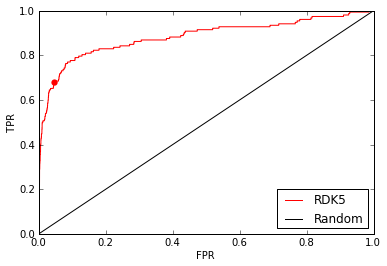

In [39]:
from rdkit.ML.Scoring import Scoring
roc = Scoring.CalcROC(sorted_scores, -1)
# number of molecules in the first 5%
num_test_mols = int(0.05 * (num_test_actives + num_test_inactives))
# figure
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.plot(roc[0], roc[1], c='r', label='RDK5') # ROC curve
plt.scatter([roc[0][num_test_mols]], [roc[1][num_test_mols]], 
            c='r', lw=0, s=40) # 5% marker
plt.plot([0, 1], [0, 1], c='k', label='Random') # random distribution
plt.legend(loc='lower right')
plt.show()

The ordering performance over the whole set can be represented by the area under the ROC curve (AUC). The AUC gives values in the range [0, 1] where 0 corresponds to all actives at the bottom, 1 corresponds to all actives on top, and 0.5 indicates random distribution. However, in this context we are mainly interested in the ranking performance in the early part of the list, e.g. the top 5%, because only these molecules will be considered for subsequent confirmatory assays. This can be measured by a so-called "early-recognition" method such as the enrichment factor at 5% (EF5%). If the ratio of actives to inactives in the test set is below 5%, the maximum value of EF5% is 20, the minimum value is 0 and a value of 1 corresponds to random distribution ([<i>J. Chem. Inf. Model.</i> (2007), <b>47</b>, 488](http://pubs.acs.org/doi/abs/10.1021/ci600426e)). This is the case here where the ratio is 0.5%. For a detailed discussion of the different evaluation methods and their differences see [<i>J. Cheminf.</i> (2013), <b>5</b>, 26](http://www.jcheminf.com/content/5/1/26).

Here, we calculate the AUC and EF5% using the RDKit implementations. 

In [40]:
auc = Scoring.CalcAUC(sorted_scores, -1)
ef = Scoring.CalcEnrichment(sorted_scores, -1, [0.05])
print "AUC = %.2f, EF5%% = %.2f" % (auc, ef[0])

AUC = 0.88, EF5% = 13.55


These results show that the actives and inactives can already be distiguished well by RDK5 similarity. By random distribution, we would have 7.6 of the 152 actives in the first 5% (i.e. 1476 molecules). Using RDK5 similarity, we have instead:

In [41]:
num_random_actives = 0.05*num_test_actives
actives_in_5percent = num_random_actives*ef[0]
print "number of actives in the first 5%% using RDK5 \
similarity = %.1f" % actives_in_5percent

number of actives in the first 5% using RDK5 similarity = 103.0


Let's have a look at the similarity distribution between the training actives and the test actives.

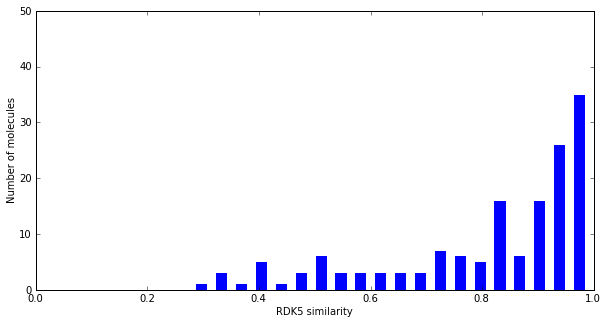

In [42]:
sim_hist = numpy.histogram([s for s,i in scores if i == 1], bins=20)
# plot it
fig = plt.figure(1, figsize=(10, 5))
plt1 = plt.subplot(111)
plt.axis([0, 1, 0, 50])
plt.xlabel('RDK5 similarity')
plt.ylabel('Number of molecules')
plt1.bar(sim_hist[1][:-1], sim_hist[0], lw=0, width=0.02)
plt.show()

As the high enrichment factor indicated, many actives in the test set have a high similarity to at least one of the training actives.

One important property of a VS-method is its so-called scaffold-hopping ability (for a review see for example [<i>Future Med. Chem.</i> (2011), <b>3</b>, 405](http://www.future-science.com/doi/full/10.4155/fmc.11.4)). This means how structurally diverse the top ranked actives are, because one is interested to know as many different active chemotypes as possible. Here, we can look at the top 20 actives and the bottom 20 actives together with the (maximum) similarities.

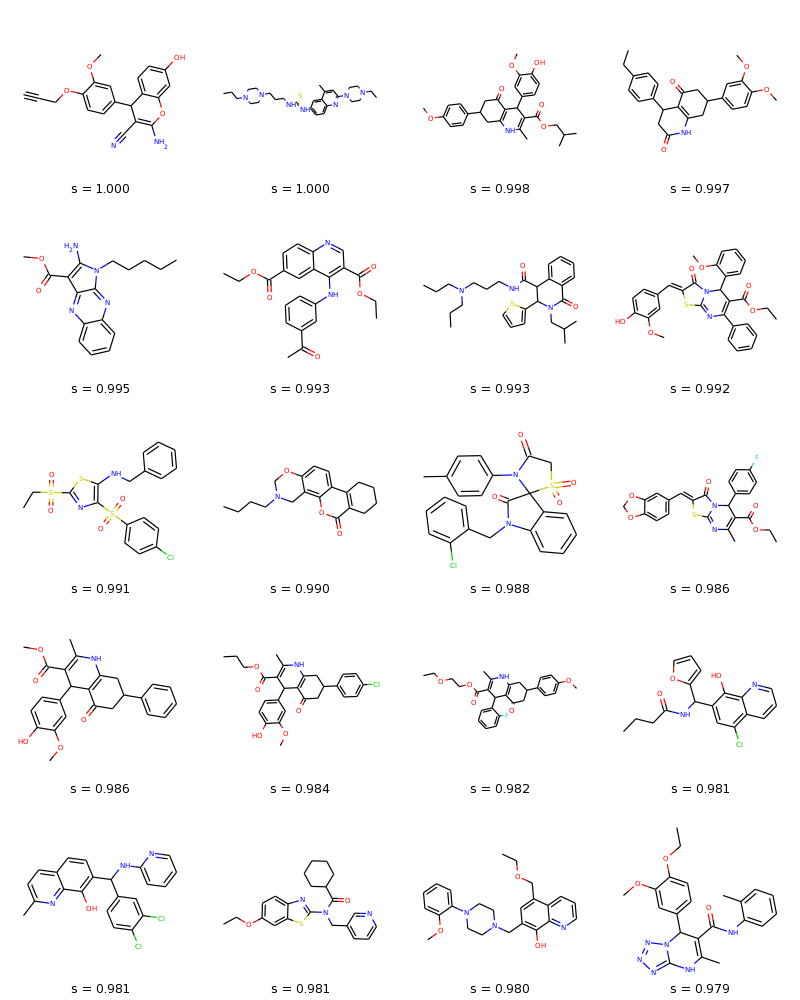

In [43]:
indices_act = [[s[0], i, s[1]] for i,s in enumerate(scores)]
indices_act.sort(reverse=True)
indices_act = [i for s,i,info in indices_act if info == 0]
# top 20 actives
Draw.MolsToGridImage([test_mols[i][1] for i in indices_act[:20]], 
    legends=[("s = %.3f" % scores[i][0]) for i in indices_act[:20]], 
    molsPerRow=4)

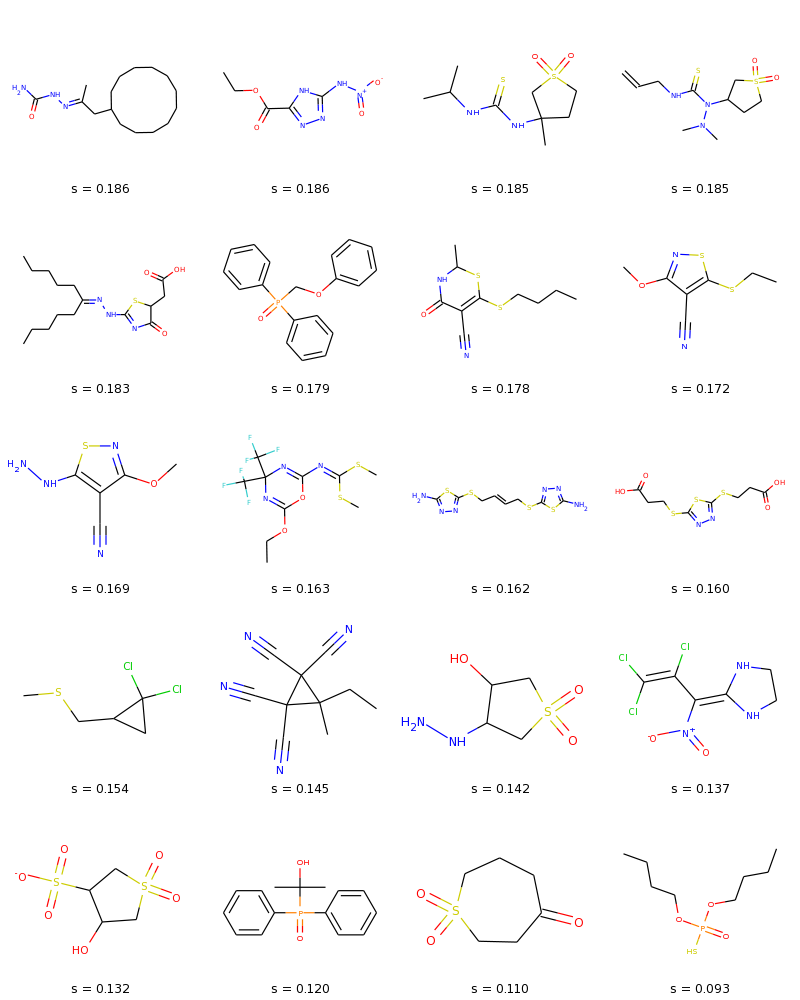

In [44]:
# bottom 20 actives
Draw.MolsToGridImage([test_mols[i][1] for i in indices_act[-20:]], 
    legends=[("s = %.3f" % scores[i][0]) for i in indices_act[-20:]], 
    molsPerRow=4)

The actives in the beginning of the ranked list are more similar than the one at the end of the list, but nevertheless many different scaffols appear already in the first 20 molecules.

Now, it's time to run first the provided script for calculate and evaluate the fingerprint similarity over 50 repetitions for the three fingerprints. The script stores the scores in the directory <i>evaluation/scores</i>, and it saves the results (AUC and EF5%) for each iteration in a file called <i>output\_analysis\_[system name].dat</i> in the directory <i>evaluation/analysis</i>. 

For the RDK5 similarity, the output looks as follows.

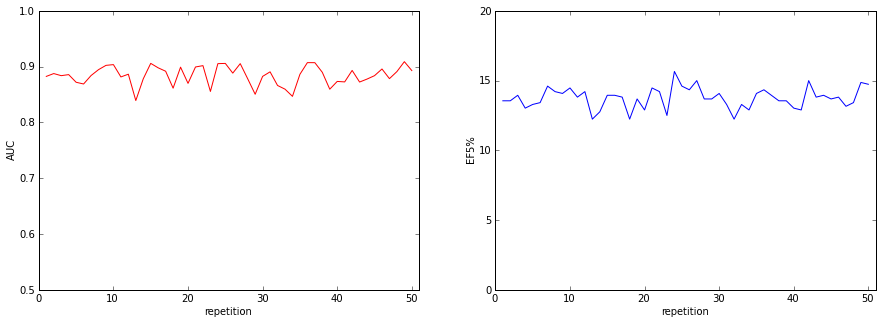

In [46]:
auc_list = []
ef5_list = []
for line in open('evaluation/analysis/output_analysis_simil_\
rdk5.dat', 'r'):
    line = line.strip().split()
    # contains: [repetition, auc, ef5%]
    auc_list.append(float(line[1]))
    ef5_list.append(float(line[2]))
# plot the lines
fig = plt.figure(1, figsize=(15, 5))
num_lists = len(auc_list)
# AUC
plt1 = plt.subplot(1,2,1)
plt.xlabel('repetition')
plt.ylabel('AUC')
plt1.axis([0, num_lists+1, 0.5, 1])
plt1.plot(range(1,num_lists+1), auc_list, c='r')
# EF5%
plt2 = plt.subplot(1,2,2)
plt.xlabel('repetition')
plt.ylabel('EF5%')
plt2.axis([0, num_lists+1, 0, 20])
plt2.plot(range(1,num_lists+1), ef5_list, c='b')

plt.show()

Although similarity-based virtual screening is quite effective, we will investigate in the following if the performance can be increased further by using a machine-learning (ML) model.

#### Machine-Learning Models

We will train models of the three ML methods - RF, NB and LR - with the three fingerprints - AP, RDK5 and Morgan2. There are three Python scripts in the folder <i>evaluation</i> for this task, one for each ML method. The scripts take the fingerprint name as argument. We will discuss here again only the important steps using LR as an example, whereas the complete scripts can be executed separately in a shell or be sent to a cluster.

The implementation of the ML methods in scikit-learn handles the input data internally as [numpy arrays](http://docs.scipy.org/doc/numpy/reference/arrays.html). The computational effort can be reduced if the fingerprints from RDKit are converted to numpy arrays beforehand. In addition, the RF implementation of scikit-learn uses floats internally, therefore it is advisable to convert the fingerprints directly to float arrays. For NB and LR, a boolean array could also be used instead (this requires less memory).

In [47]:
# helper function to convert fingerprints from RDKit to numpy arrays
def getNumpyArrays(fplist):
    nplist = []
    for fp in fplist:
        arr = numpy.zeros((1,), numpy.float32)
        DataStructs.ConvertToNumpyArray(fp, arr)
        nplist.append(arr)
    return nplist
        
np_fps_act = getNumpyArrays(fps_act)
np_fps_inact = getNumpyArrays(fps_inact)

In contrast to the similarity calculation, we also need the fingerprints of the inactives for training the model, so we add them to the active ones. In addition, we need an array with the active/inactive information (i.e. 1/0) of the training molecules.

In [48]:
train_indices_inact = \
set(range(num_inactives)).difference(test_indices_inact)

train_np_fps = [np_fps_act[i] for i in train_indices_act] \
+ [np_fps_inact[i] for i in train_indices_inact]

train_info = [1]*(num_actives-num_test_actives) \
+ [0]*(num_inactives-num_test_inactives)

print "number of training actives = %i" % len(train_fps)
print "total number of training molecules = %i" % len(train_info)

number of training actives = 1376
total number of training molecules = 265622


With the training fingerprints and class information at hand, we can go on to train the ML model. For the LR, we use the [default parameters of scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Attention: this step may take a while.

In [49]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_np_fps, train_info)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

Using the trained model, we can get predictions for the test molecules. The function <i>predict\_proba()</i> returns for each input sample the predicted probability for both classes (class 0 and class 1). Here, we are only interested in the probability for class 1 (i.e. active) and we can discard the one for class 0. 

In [50]:
test_np_fps = [np_fps_act[i] for i in test_indices_act] \
+ [np_fps_inact[i] for i in test_indices_inact]

# keep only the probability for class 1
probabilities = [pp[1] for pp in model.predict_proba(test_np_fps)] 

In order to be able to break ties based on the chemical similarity, we add the previously calculated similarities as the second column to the probabilities. In addition, we add the class information as a third column. Then, we sort the list by descending probability.

In [51]:
ml_scores = [(pp, s[0], s[1]) for pp,s in zip(probabilities, scores)]
# sorting by descending probability
sorted_ml_scores = sorted(ml_scores, reverse=True) 

Now, we can compare the ROC curve of the ML model with that of the chemical similarity (the filled circle indicates the 5% cutoff).

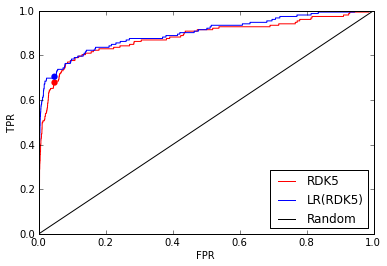

In [52]:
ml_roc = Scoring.CalcROC(sorted_ml_scores, -1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0.0, 1.0, 0.0, 1.0])
# ROC curve for the similarities
plt.plot(roc[0], roc[1], c='r', label='RDK5') 
plt.scatter([roc[0][num_test_mols]], [roc[1][num_test_mols]], 
            c='r', lw=0, s=40) # 5% marker
# ROC curve for LR(RDK5)
plt.plot(ml_roc[0], ml_roc[1], c='b', label='LR(RDK5)') 
plt.scatter([ml_roc[0][num_test_mols]], [ml_roc[1][num_test_mols]], 
            c='b', lw=0, s=40) # 5% marker
# random distribution
plt.plot([0, 1], [0, 1], c='k', label='Random') 
plt.legend(loc='lower right')
plt.show()

And the AUC and EF5% values are:

In [53]:
auc = Scoring.CalcAUC(sorted_ml_scores, -1)
ef = Scoring.CalcEnrichment(sorted_ml_scores, -1, [0.05])
print "AUC = %.2f, EF5%% = %.2f" % (auc, ef[0])

AUC = 0.90, EF5% = 14.08


From the comparison of ROC curves, it is evident that the LR(RDK5) model yields a marginally higher enrichment of actives in the beginning. This is reflected in the higher EF5% value. Also the AUC value increases slightly.

At this point, we need to run the scripts to train and evaluate each of the 9 ML method/fingerprint combinations over 50 repetitions. For the ML models, the script saves only the ranks of the actives and not the complete scores. The evaluation results (AUC and EF5%) are saved for each repetition in <i>evaluation/analysis</i>.

#### Comparison of the Models

The next step is to compare the different ML models with each other and also with the fingerprint similarities. First, we calculate the average AUC and EF5% values over the 50 repetitions.

In [54]:
# names of the methods
names = ['simil_ap', 'simil_rdk5', 'simil_morgan2', 'nb_ap', 'nb_rdk5', 
         'nb_morgan2', 'lr_ap', 'lr_rdk5', 'lr_morgan2', 'rf_ap', 
         'rf_rdk5', 'rf_morgan2']
# loop over the names
outfile = open('evaluation/analysis/averaged_results.dat', 'w')
outfile.write("#Model\tAUC\tSTD\tEF5%\tSTD\n") # header
for name in names:
    auc_list = []
    ef5_list = []
    # loop over repetitions
    for line in open('evaluation/analysis/output_analysis_'+name+'.dat', 
                     'r'):
        line = line.strip().split()
        auc_list.append(float(line[1]))
        ef5_list.append(float(line[2]))
    # calculate averages
    ave_auc = numpy.average(auc_list)
    std_auc = numpy.std(auc_list)
    ave_ef5 = numpy.average(ef5_list)
    std_ef5 = numpy.std(ef5_list)
    # write the averages to the file
    outfile.write("%s\t%.5f\t%.5f\t%.5f\t%.5f\n" % (name, ave_auc, 
                                        std_auc, ave_ef5, std_ef5))
outfile.close()

In [55]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from collections import defaultdict
data_dict = defaultdict(list)
for line in open('evaluation/analysis/averaged_results.dat', 'r'):
    if line[0] == "#": continue # ignore header
    line = line.strip().split()
    data_dict['Method'].append(line[0])
    data_dict['AUC'].append(float(line[1]))
    data_dict['STD_AUC'].append(float(line[2]))
    data_dict['EF5%'].append(float(line[3]))
    data_dict['STD_EF5%'].append(float(line[4]))
results = pd.DataFrame(data_dict)
results[['Method', 'AUC', 'STD_AUC', 'EF5%', 'STD_EF5%']]

,Method,AUC,STD_AUC,EF5%,STD_EF5%
0,simil_ap,0.87585,0.01790,13.93833,0.69205
1,simil_rdk5,0.88399,0.01693,13.74627,0.74004
2,simil_morgan2,0.88704,0.01630,14.65392,0.68504
3,nb_ap,0.80304,0.01998,7.40326,0.63743
4,nb_rdk5,0.81025,0.02063,8.26881,0.79712
5,nb_morgan2,0.84651,0.02068,10.41823,0.97945
6,lr_ap,0.87787,0.01709,12.53081,0.92111
7,lr_rdk5,0.90886,0.01717,14.99067,0.80358
8,lr_morgan2,0.88325,0.01619,13.29903,0.74656
9,rf_ap,0.92245,0.01426,14.65918,0.74929


Looking at the results, we can conclude that the NB models do not work well for this data set as their performance is worse than that of the corresponding fingerprint similarity. For LR, only LR(RDK5) is performing better, whereas the RF models yield the best AUC and enrichment values.

Because similarity-based VS works so well on this data set, there is not a huge amount of room for improvement with the ML models.

But we are not only interested in how good a model is, we also would like to know how different the rankings are, i.e. do the models find different actives. This is especially important with regard to classifier fusion where we combine multiple models in a fusion model. One way to measure the difference in ranking of two models is by calculating the [Pearson correlation coefficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) <i>P</i> of the two ranked lists. A value <i>P</i> = 1 and -1 correspond to exact linear relationship, and P = 0 indicates no correlation. To calculate <i>P</i>, we use the [implementation of scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html). 

Here, we calculate as an example the Pearson correlation coefficient between the ranks of the actives from LR(RDK5) and RDK5 fingerprint similarity. 

In [56]:
from scipy.stats import pearsonr
# RDK5: get similarity and indices
idx_rdk5 = [(s[0], i) for i,s in enumerate(scores)]
# LR(RDK5): get probability, similarity and indices
idx_ml = [(s[0], s[1], i) for i,s in enumerate(ml_scores)]
# sort by descending similarity or probability
idx_rdk5.sort(reverse=True)
idx_ml.sort(reverse=True)
# add ranks (highest = best) and sort again by asscending index
num = len(idx_rdk5)
idx_rdk5 = [(idx[-1], num-j) for j,idx in enumerate(idx_rdk5)]
idx_rdk5.sort()
idx_ml = [(idx[-1], num-j) for j,idx in enumerate(idx_ml)]
idx_ml.sort()
# keep only the ranks of the actives
idx_rdk5 = [r for idx,r in idx_rdk5[:num_test_actives]]
idx_ml = [r for idx,r in idx_ml[:num_test_actives]]
# calculate pearson correlation coefficient for the actives
p = pearsonr(idx_rdk5, idx_ml)
print "Pearson correlation coefficient = %.3f" % (p[0]) 

Pearson correlation coefficient = 0.656


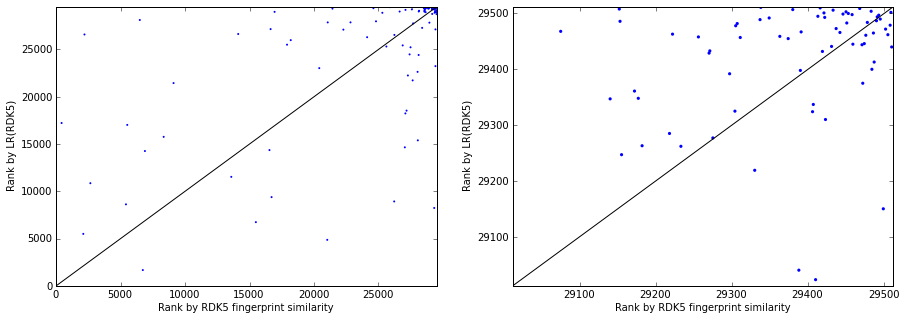

In [57]:
fig = plt.figure(1, figsize=(15, 5))
plt1 = plt.subplot(1,2,1)
plt.xlabel('Rank by RDK5 fingerprint similarity')
plt.ylabel('Rank by LR(RDK5)')
plt1.axis([0, num, 0, num])
plt1.plot([0, num], [0, num], c='k')
plt1.scatter(idx_rdk5, idx_ml, s=4, lw=0)

# close up
plt2 = plt.subplot(1,2,2)
plt.xlabel('Rank by RDK5 fingerprint similarity')
plt.ylabel('Rank by LR(RDK5)')
plt2.axis([num-500, num, num-500, num])
plt2.plot([num-500, num], [num-500, num], c='k')
plt2.scatter(idx_rdk5, idx_ml, s=10, lw=0)

plt.show()

This indicates that for this one test set, there is some correlation between the ranks of the actives: the methods will return somewhat diverse actives, but there will be some overlap between the hitlists. Interesting are thereby especially the outliers with a high (=good) rank for one method but a low rank for the other.

In the directory <i>evaluation</i> there is a script called <i>calculate\_pearson\_correlation.py</i> which will calculate the Pearson correlation coefficient between the different ML models and average over the repetitions. We do this for the RF and LR models (we leave the NB models out as they clearly perform worse). The results are:

In [58]:
data_dict = defaultdict(list)
for line in open('evaluation/analysis/pearson_correlation.dat', 'r'):
    if line[0] == "#": continue # ignore header
    line = line.strip().split()
    data_dict['Model1-Model2'].append(line[0])
    data_dict['Ave_Pearson'].append(float(line[1]))
    data_dict['STD'].append(float(line[2]))
results = pd.DataFrame(data_dict)
results[['Model1-Model2', 'Ave_Pearson', 'STD']]

,Model1-Model2,Ave_Pearson,STD
0,rf_ap-rf_rdk5,0.578,0.019
1,rf_ap-rf_morgan2,0.201,0.023
2,rf_ap-lr_ap,0.504,0.020
3,rf_ap-lr_rdk5,0.335,0.026
4,rf_ap-lr_morgan2,0.400,0.022
5,rf_rdk5-rf_morgan2,0.202,0.025
6,rf_rdk5-lr_ap,0.412,0.023
7,rf_rdk5-lr_rdk5,0.464,0.023
8,rf_rdk5-lr_morgan2,0.413,0.024
9,rf_morgan2-lr_ap,0.176,0.022


The best three models based on the EF5% values are RF(RDK5), RF(Morgan2) and LR(RDK5). The Pearson correlation coeffients between the three models indicate that the models give a fairly different ranking of the actives, i.e. they contain complementary information (especially RF(Morgan2) compared to RF(RDK5) and LR(RDK5)).

#### Classifier Fusion

The best (and complementary) ML models found above can be combined using heterogeneous classifier fusion. How many models are combined is a trade-off between computational cost and prediction performance. Here, we will combine the three models: RF(RDK5), RF(Morgan2) and LR(RDK5) using the same approach as in our [previous publication](http://pubs.acs.org/doi/abs/10.1021/ci400466r): the predictions of the three models are combined by MAX rank-based fusion. The molecules are ranked by each model separately and then the maximum observed rank is stored as the "combined" rank (and the maximum observed probability as the "combined" probability). Afterwards, the molecules are ranked again based on the combined rank and ties are broken based on the combined probability value.

Here, we discuss again the individual steps of the approach. A Python script is available in the directory <i>evaluation</i> for the full analysis.

First, we need the Morgan2 fingerprints:

In [59]:
# actives
fps_act_morgan2 = []
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    line = line.rstrip().split()
    # contains: [sample_id, hit, pec50, smiles]
    m = Chem.MolFromSmiles(line[3])
    fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) 
    fps_act_morgan2.append(fp)
# inactives
fps_inact_morgan2 = []
for line in gzip.open('data/training_inactives_cleaned.dat.gz', 'r'):
    line = line.rstrip().split()
    m = Chem.MolFromSmiles(line[3])
    fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    fps_inact_morgan2.append(fp)

These are used to calculate the fingerprint similarities.

In [60]:
test_fps_morgan2 = [fps_act_morgan2[i] for i in test_indices_act] \
+ [fps_inact_morgan2[i] for i in test_indices_inact]

train_fps_morgan2 = [fps_act_morgan2[i] for i in range(num_actives) \
                     if i not in test_indices_act]

scores_morgan2 = []
for fp, info in zip(test_fps_morgan2, test_info):
    similarities = DataStructs.BulkTanimotoSimilarity(fp, 
                                                train_fps_morgan2)
    # sort by descending similarity
    similarities.sort(reverse=True)
    scores_morgan2.append((similarities[0], info))

Now, we convert the Morgan2 fingerprints to numpy arrays and then we train the random forests with the two fingerprints, RDK5 and Morgan2. 

In [61]:
np_fps_act_morgan2 = getNumpyArrays(fps_act_morgan2)
np_fps_inact_morgan2 = getNumpyArrays(fps_inact_morgan2)
# for training
train_np_fps_morgan2 = [np_fps_act_morgan2[i] for i in train_indices_act] \
+ [np_fps_inact_morgan2[i] for i in train_indices_inact]
# for testing
test_np_fps_morgan2 = [np_fps_act_morgan2[i] for i in test_indices_act] \
+ [np_fps_inact_morgan2[i] for i in test_indices_inact]

For the RF models, we use 100 trees and a maximum depth = 10, the minimum samples to split are 2 and minimum 1 sample is required in a leaf. In addition, we give a seed for the random-number generator (<i>random\_state</i>). For the other parameters, the [default values from scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) are taken. 

Our data set is very unbalanced, i.e. we have many more samples for the inactive class than we have for the active class. Whereas the LR models can handle this inbalance, we have to use a balancing algorithm for the RFs. Here, we use a [downsampling algorithm](http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf) where all samples of the minor class are taken but only an equal number of randomly selected samples of the major class. We can introduce this downsampling procedure into the scikit-learn RF using a so-called [monkey patch](http://en.wikipedia.org/wiki/Monkey_patch). We have written the monkey patch into a file called <i>random\_forest\_functions.py</i> which we now load and apply.

Attention: The provided balancing function is for sklearn version 0.13.0. It might not work anymore with later versions.

In [62]:
import random_forest_functions as rfmethod
from sklearn.ensemble import forest
# monkey patch
forest._parallel_build_trees = rfmethod._balanced_parallel_build_trees 

Now, we can train the RFs. Attention: this step may take a while.

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf_rdk5 = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                 min_samples_split=2, 
                                 min_samples_leaf=1, 
                                 random_state=23)
rf_rdk5.fit(train_np_fps, train_info)

RandomForestClassifier(bootstrap=True, compute_importances=False,
            criterion='gini', max_depth=10, max_features='auto',
            min_density=0.1, min_samples_leaf=1, min_samples_split=2,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=23,
            verbose=0)

In [64]:
rf_morgan2 = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    random_state=121)
rf_morgan2.fit(train_np_fps_morgan2, train_info)

RandomForestClassifier(bootstrap=True, compute_importances=False,
            criterion='gini', max_depth=10, max_features='auto',
            min_density=0.1, min_samples_leaf=1, min_samples_split=2,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=121,
            verbose=0)

With the three trained models at hand, we can get predictions for the test molecules from each model and assign ranks to them.

In [65]:
# the probabilities from LR(RDK5) are stored 
# in the variable "probabilities"
# keep only the probability for class 1
proba_rf_rdk5 = [pp[1] for pp in rf_rdk5.predict_proba(test_np_fps)]
proba_rf_morgan2 = [pp[1] for pp in 
                    rf_morgan2.predict_proba(test_np_fps_morgan2)]

# helper function to assign ranks
# input: list of probabilities and list of similarities
def assignRanks(plist, slist): 
    num = len(plist)
    # combine the lists and add the index
    tmplist = [(plist[i], slist[i][0], i) for i in range(num)]
    # sort by descending probability
    tmplist.sort(reverse=True)
    # add the rank: highest = best
    # store: [index, rank, proba, similarity]
    tmplist = [(t[2], num-i, t[0], t[1]) for i,t in enumerate(tmplist)]
    # sort by ascending index to return to the original order
    tmplist.sort()
    # remove the index
    return [(rank, p, s) for i,rank,p,s in tmplist]

scores_lr_rdk5 = assignRanks(probabilities, scores)
scores_rf_rdk5 = assignRanks(proba_rf_rdk5, scores)
scores_rf_morgan2 = assignRanks(proba_rf_morgan2, scores_morgan2)

Now, we fuse the predictions of the three models based on the ranks and evaluate the performance.

In [66]:
fusion_scores = []
for m1, m2, m3, info in zip(scores_lr_rdk5, scores_rf_rdk5, 
                            scores_rf_morgan2, test_info):
    rank = max([m1[0], m2[0], m3[0]]) # maximum rank
    pp = max([m1[1], m2[1], m3[1]]) # maximum probability
    # store: [max rank, max proba, similarity, act/inact info]
    fusion_scores.append([rank, pp, m1[2], info])
# sort by descending rank
fusion_scores.sort(reverse=True)

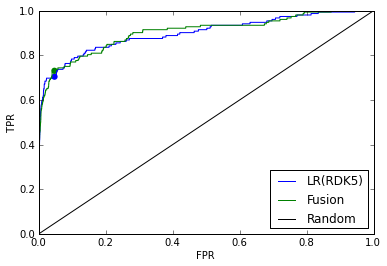

In [67]:
fusion_roc = Scoring.CalcROC(fusion_scores, -1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
# ROC curve for the LR(RDK5) model
plt.plot(ml_roc[0], ml_roc[1], c='b', label='LR(RDK5)')
plt.scatter([ml_roc[0][num_test_mols]], [ml_roc[1][num_test_mols]], 
            c='b', lw=0, s=40) # 5% marker
# ROC curve for the fusion model
plt.plot(fusion_roc[0], fusion_roc[1], c='g', label='Fusion')
plt.scatter([fusion_roc[0][num_test_mols]], [fusion_roc[1][num_test_mols]], 
            c='g', lw=0, s=40) # 5% marker
# random distribution
plt.plot([0, 1], [0, 1], c='k', label='Random') 
plt.legend(loc='lower right')
plt.show()

In [68]:
auc = Scoring.CalcAUC(fusion_scores, -1)
ef = Scoring.CalcEnrichment(fusion_scores, -1, [0.05])
print "AUC = %.2f, EF5%% = %.2f" % (auc, ef[0])

AUC = 0.90, EF5% = 14.60


The script <i>train\_evaluate\_fusion.py</i> in the directory <i>evaluation</i> performs the same procedure for the 50 repetitions and writes the results to the file <i>output\_analysis\_[system name].dat</i> in the directory <i>evaluation/analysis</i>. After we ran the script in a shell or on a cluster, we can calculate the average results.

In [98]:
auc_list = []
ef5_list = []
# loop over repetitions
for line in open('evaluation/analysis/output_analysis_fusion.dat', 'r'):
    line = line.strip().split()
    auc_list.append(float(line[1]))
    ef5_list.append(float(line[2]))
# calculate averages
ave_auc = numpy.average(auc_list)
std_auc = numpy.std(auc_list)
ave_ef5 = numpy.average(ef5_list)
std_ef5 = numpy.std(ef5_list)
print "Fusion: <AUC> = %.2f (STD = %.2f), <EF5%%> = %.2f (STD = %.2f)" % \
(ave_auc, std_auc, ave_ef5, std_ef5)

# write the average to the file
outfile = open('evaluation/analysis/averaged_results_fusion.dat', 'w')
outfile.write("#Model\tAUC\tSTD\tEF5%\tSTD\n") # header
outfile.write("%s\t%.5f\t%.5f\t%.5f\t%.5f\n" % ('fusion', ave_auc, std_auc, 
                                                ave_ef5, std_ef5))
outfile.close()

Fusion: <AUC> = 0.93 (STD = 0.01), <EF5%> = 15.75 (STD = 0.73)


When we compare the results for the fusion model with the ones of the individual models, we see that the AUC value has remained similar compared to the one of RF(Morgan2) and RF(RDK5), whereas the EF5% value has increased slightly. The latter is what we are most interested in for virtual screening.

#### Final Fusion Model

After we have found a promising fusion model using the "leave-10%-out" approach, we can go on and build the individual models using all available molecules. There are two scripts called <i>train\_[LR/RF]\_model.py</i> in the directory <i>final\_models</i>. We run the first one for RF with both fingerprints, "rdk5" and "morgan2", and the second one for LR with "rdk5" in a shell or on a cluster. After they completed, we find three [pickled](http://docs.python.org/3.3/library/pickle.html) (binary format) and gzipped file in the same directory: <i>rf\_rdk5\_model.pkl.gz</i>, <i>rf\_morgan2\_model.pkl.gz</i>, <i>lr\_rdk5\_model.pkl.gz</i>. 

We load the models now.

In [70]:
import cPickle
rf_rdk5_final = cPickle.load(gzip.open('final_models/rf_\
rdk5_model.pkl.gz', 'r'))

rf_morgan2_final = cPickle.load(gzip.open('final_models/rf_\
morgan2_model.pkl.gz', 'r'))

lr_rdk5_final = cPickle.load(gzip.open('final_models/lr_\
rdk5_model.pkl.gz', 'r'))

#### External Test Set

This final fusion model will be used to rank order the molecules in an external test set. These molecules are found in the file <i>malariahts\_externaltestset.txt</i> which we downloaded from the [TDT website](http://www.tdtproject.org/challenge-1---malaria-hts.html) and saved in the directory <i>data</i>. The file contains two columns:

- sample ID (SAMPLE)
- canonical SMILES

Firstly, we check again the provided SMILES.

In [71]:
count = 0
count_mols = 0
outfile = open('data/external_testset_cleaned.dat', 'w')
for line in open('data/malariahts_externaltestset.txt', 'r'):
    if line[0] == "#": continue
    count_mols += 1
    line = line.strip().split()
    # contains: [sample_id, smiles]
    m = Chem.MolFromSmiles(line[1])
    if m is not None:
        outfile.write("%s\t%s\n" % (line[0], line[1]))
    else:
        count += 1
outfile.close()
print "number of molecules in external testset =", count_mols
print "number of molecules with RDKit-invalid SMILES =", count

number of molecules in external testset = 1056
number of molecules with RDKit-invalid SMILES = 0


Secondly, we generate fingerprints for the test molecules and calculate the fingerprint similarities.

In [72]:
test_fps_rdk5 = []
test_fps_morgan2 = []
test_mols = []
for line in open('data/external_testset_cleaned.dat', 'r'):
    line = line.strip().split()
    # contains: [sample_id, smiles]
    m = Chem.MolFromSmiles(line[1])
    test_fps_rdk5.append(Chem.RDKFingerprint(m, maxPath=5))
    test_fps_morgan2.append(AllChem.GetMorganFingerprintAsBitVect(m, 
                                                     2, nBits=1024))
    test_mols.append((m, line[0]))
print "number of test fingerprints =", len(test_fps_rdk5)

number of test fingerprints = 1056


In [73]:
# RDK5 similarities
scores_rdk5 = []
for fp,m in zip(test_fps_rdk5, test_mols):
    similarities = DataStructs.BulkTanimotoSimilarity(fp, fps_act)
    # sort by descending similarity
    similarities.sort(reverse=True)
    # store: [similarity, sample_id]
    scores_rdk5.append((similarities[0], m[1]))

In [74]:
# Morgan2 similarities
scores_morgan2 = []
for fp,m in zip(test_fps_morgan2, test_mols):
    similarities = DataStructs.BulkTanimotoSimilarity(fp, 
                                          fps_act_morgan2)
    # sort by descending similarity
    similarities.sort(reverse=True)
    scores_morgan2.append((similarities[0], m[1]))

And finally, we convert the fingerprints to numpy arrays and generate predictions for them followed by fusion.

In [75]:
test_np_fps_rdk5 = getNumpyArrays(test_fps_rdk5)
test_np_fps_morgan2 = getNumpyArrays(test_fps_morgan2)

In [76]:
# generate predictions
# keep only the probability for class 1
proba_lr_rdk5 = [pp[1] for pp in \
                 lr_rdk5_final.predict_proba(test_np_fps_rdk5)] 
proba_rf_rdk5 = [pp[1] for pp in \
                 rf_rdk5_final.predict_proba(test_np_fps_rdk5)]
proba_rf_morgan2 = [pp[1] for pp in \
                    rf_morgan2_final.predict_proba(test_np_fps_morgan2)]

# assign ranks
scores_lr_rdk5 = assignRanks(proba_lr_rdk5, scores_rdk5)
scores_rf_rdk5 = assignRanks(proba_rf_rdk5, scores_rdk5)
scores_rf_morgan2 = assignRanks(proba_rf_morgan2, scores_morgan2)

# fusion
fusion_scores = []
for m1, m2, m3, m in zip(scores_lr_rdk5, scores_rf_rdk5, 
                         scores_rf_morgan2, test_mols):
    rank = max([m1[0], m2[0], m3[0]]) # maximum rank
    pp = max([m1[1], m2[1], m3[1]]) # maximum probability
    # store: [max rank, max proba, similarity, sample_id]
    fusion_scores.append([rank, pp, m1[2], m[1]])
# sort by descending rank
fusion_scores.sort(reverse=True)

The top twelve molecules are:

In [77]:
data = pd.DataFrame({'max rank':[f[0] for f in fusion_scores[:12]], 
                     'max proba':[f[1] for f in fusion_scores[:12]],
                     'similarity':[f[2] for f in fusion_scores[:12]],
                     'sample_id':[f[3] for f in fusion_scores[:12]]})
data[['sample_id', 'max rank', 'max proba', 'similarity']]

,sample_id,max rank,max proba,similarity
0,SJ000550923-1,1056,1.000000,0.995680
1,SJ000550375-1,1056,1.000000,0.984615
2,SJ000550782-1,1056,0.999898,0.913958
3,SJ000551649-1,1055,1.000000,0.989744
4,SJ000550704-1,1055,1.000000,0.868687
5,SJ000550778-1,1055,0.982943,0.689524
6,SJ000550864-1,1054,1.000000,0.979381
7,SJ000550373-1,1054,0.990000,0.991285
8,SJ000550651-1,1054,0.969252,0.668998
9,SJ000550391-1,1053,1.000000,0.957627


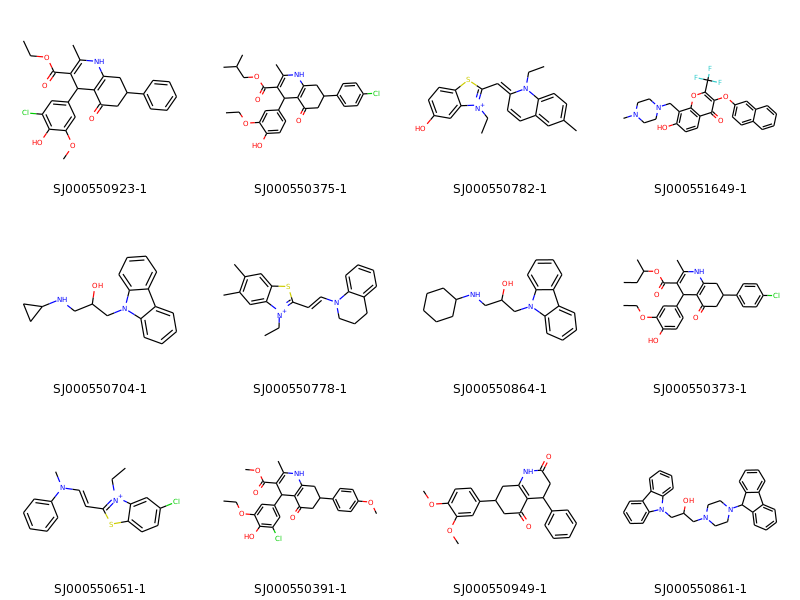

In [78]:
mols = {}
for m in test_mols:
    mols[m[1]] = m[0]
Draw.MolsToGridImage([mols[k] for k in data['sample_id']], 
                     legends=data['sample_id'], molsPerRow=4)

Molecule 5 (SJ000550778-1) and 8 (SJ000550651-1) have a lower maximum fingerprint similarity compared to the other molecules among the top twelve, although all of them have a high predicted probability. One way to find out which parts of a molecule make the ML model think it is active, is to generate a "similarity map" ([<i>J. Cheminf.</i> (2013), <b>5</b>, 43](http://www.jcheminf.com/content/5/1/43)). Currently, the maps can be constructed for models built with either AP, topological torsions (TT), or Morgan fingerprints. Here, we generate therefore the map for the RF(Morgan2) model.

In [79]:
idx = 'SJ000550651-1'
fp = AllChem.GetMorganFingerprintAsBitVect(mols[idx], 2, nBits=1024)
print "RF(Morgan2) probability = %.3f" % \
rf_morgan2_final.predict_proba(fp)[0][1]

RF(Morgan2) probability = 0.800


Maximum probability difference found = 0.21


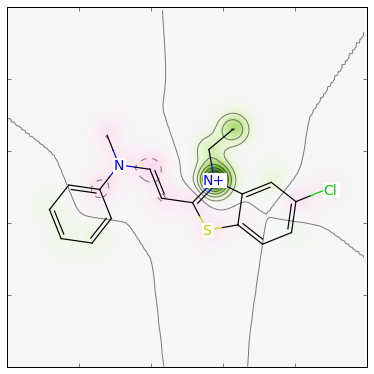

In [80]:
from rdkit.Chem.Draw import SimilarityMaps as sm

# helper function: return probability to be active (class 1) 
# for a given fp and model
def getProba(fp, predictionFunction):
  return predictionFunction(fp)[0][1]

fig, maxweight = sm.GetSimilarityMapForModel(mols[idx], 
                 lambda x,y: sm.GetMorganFingerprint(x, atomId=y, 
                                                     nBits=1024), 
                 lambda x: getProba(x, rf_morgan2_final.predict_proba), 
                 size=(200, 200))
print "Maximum probability difference found =", maxweight

The random forest has focused on a small piece of the molecule: the charged nitrogen in the benzothiazole ring.

We store the rank ordered list in the directory <i>results</i>.

In [81]:
outfile = open('results/rank_ordered_list_external_testset.txt', 'w')
outfile.write("#SAMPLE\tSMILES\tMax_Rank\tMax_Probability\r\n")
for r, p, s, idx in fusion_scores:
    # write: [sample_id, smiles, max rank, max proba]
    outfile.write("%s\t%s\t%i\t%.5f\r\n" % (idx, 
    Chem.MolToSmiles(mols[idx], isomericSmiles=True), r, p))
outfile.close()

## Task 3: Follow-Up Hit Finding

The previously developed fusion model (consisting of three individual ML models) can be used to screen a larger, more diverse set of commercially available compounds for the identifaction of new actives. To this end, we have downloaded the "parent" list of commercially available compounds from [eMolecules](http://downloads.emolecules.com/ordersc) in January 2014. This list contains the SMILES and identifier of 5'488'503 molecules.

Before we get any predictions, we filter the compounds based on a RDKit-readable SMILES and the property filters explained in Task 1 (except logP calculation). For this, we run the script <i>pre-filter\_commercial\_compounds.py</i> in the directory <i>hit\_finding</i> in a shell or on a cluster. After the scripts has run, we are left with 4'426'285 compounds.

The steps to rank order the commercially available compounds are the same as for the external test set:

* <b>Calculation of fingerprint similarities:</b> The fingerprint similarity is calculated using the script <i>calculate\_similarity.py</i> in the directory <i>hit\_finding</i> which takes the fingerprint name as argument. We run the script once for RDK5 and once for Morgan2. The ranked lists are pickled and written to a file called <i>scores\_[fingerprint name].pkl.gz</i>

* <b>Generating predictions from the three ML models and fusion:</b> The script <i>rank\_order\_compounds\_by\_fusion.py</i> in the directory <i>hit\_finding</i> reads the commercially available molecules, calculates the fingerprints, converts them to numpy arrays and generates predictions using the previously trained ML models (Task 2). The molecules are then ranked by the predicted probability, where ties are broken using the fingerprint similarity calculated in step 1. The "combined" rank is the maximum rank of the three ML models and the molecules are ranked again according to this combined rank. The 10K top-ranked compounds are written to a file called <i>ranked\_list\_top10K\_commercial\_cmps.dat.gz</i>.

After the script has finished, we can read in the ranked list of the top 10K commercially available molecules.

In [69]:
fusion_scores_comm = {}
scores_identifiers = []
for line in gzip.open('hit_finding/ranked_list_top10K_\
commercial_cmps.dat.gz', 'r'):
    if line[0] == "#": continue
    line = line.rstrip().split()
    # contains: [identifier, SMILES, max rank, max proba, similarity]
    fusion_scores_comm[line[0]] = line
    scores_identifiers.append(line[0])
print "number of molecules =", len(fusion_scores_comm)

number of molecules = 10000


The top twelve molecules are:

In [70]:
data_c = pd.DataFrame({'max rank':[fusion_scores_comm[k][2] for k in scores_identifiers[:12]], 
                     'max proba':[fusion_scores_comm[k][3] for k in scores_identifiers[:12]],
                     'similarity':[fusion_scores_comm[k][4] for k in scores_identifiers[:12]],
                     'identifier':[fusion_scores_comm[k][0] for k in scores_identifiers[:12]]})
data_c[['identifier', 'max rank', 'max proba', 'similarity']]

,identifier,max rank,max proba,similarity
0,45583598,4545200,1.00000,1.00000
1,32854739,4545200,1.00000,1.00000
2,46347892,4545200,1.00000,0.66585
3,43012530,4545199,1.00000,1.00000
4,32499777,4545199,1.00000,1.00000
5,45944591,4545199,1.00000,0.73284
6,32499771,4545198,1.00000,1.00000
7,4425665,4545198,1.00000,0.34211
8,32499769,4545197,1.00000,1.00000
9,31748140,4545197,0.99999,0.34651


In [71]:
comm_mols = [(Chem.MolFromSmiles(fusion_scores_comm[k][1]), \
              fusion_scores_comm[k][0]) for k in scores_identifiers]

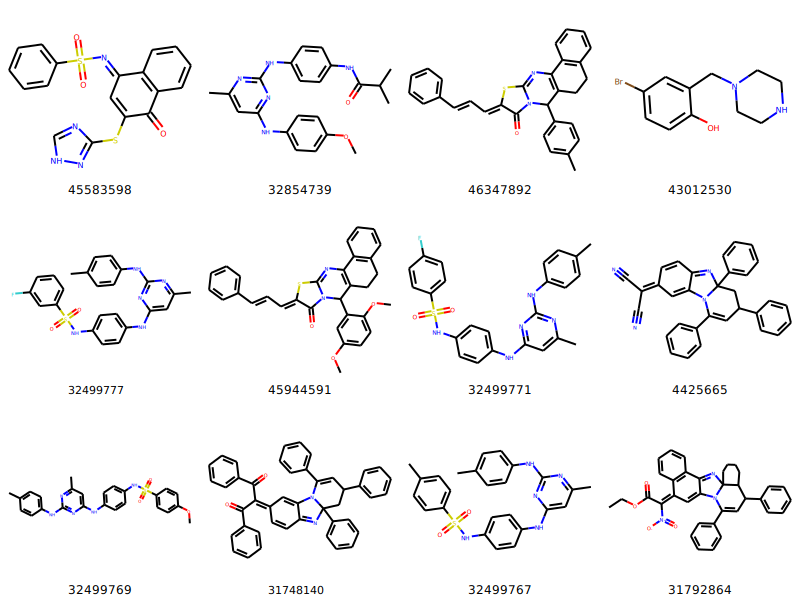

In [72]:
Draw.MolsToGridImage([m[0] for m in comm_mols[:12]], 
                     legends=[m[1] for m in comm_mols[:12]], 
                     molsPerRow=4)

#### Removal of compounds from the primary HTS screen

Some of the active molecules tested in the primary screen that we used for training may also be present in the eMolecules catalog. As the focus here is to find new active molecules, we remove these compounds. We keep molecules with ambiguous results as these may still be interesting to test in a confirmatory assay.

We check if two compounds are the same by comparing their SMILES strings. Note that only SMILES generated by the same program can be safely compared, as different programs may use different canonicalisation algorithms to obtain a unique numbering of the atoms in a molecule.

In [73]:
smiles_primary = []
for line in gzip.open('data/training_actives_cleaned.dat.gz', 'r'):
    if line[0] == "#": continue
    line = line.strip().split()
    smiles_primary.append(Chem.MolToSmiles(Chem.MolFromSmiles(line[3]), isomericSmiles=True))

In [74]:
new_mols = []
known_mols = 0
for m,idx in comm_mols:
    if Chem.MolToSmiles(m) in smiles_primary:
        known_mols += 1
    else:
        new_mols.append((m, idx))
comm_mols = new_mols
print "number of remaining molecules", len(comm_mols) 

number of remaining molecules 9287


#### Property and Substructure Filters

To select the 1000 molecules for a subsequent confirmatory assay, we will go through the same filtering procedure as in Task 1. All of the property filters except logP we have already done before the ranking. So, now we calculate the logP of the top 10K compounds and exclude does with logP < -5 and logP > 7.5.

In [75]:
new_mols = []
bad_mols = []
for m,idx in comm_mols:
    logp = Crippen.MolLogP(m)
    if logp < -5 or logp > 7.5:
        bad_mols.append((m, idx))
    else:
        new_mols.append((m, idx))
comm_mols = new_mols
print "number of molecules with -5 < logP < 7.5 =", len(comm_mols) 

number of molecules with -5 < logP < 7.5 = 9153


Some of the discarded molecules are:

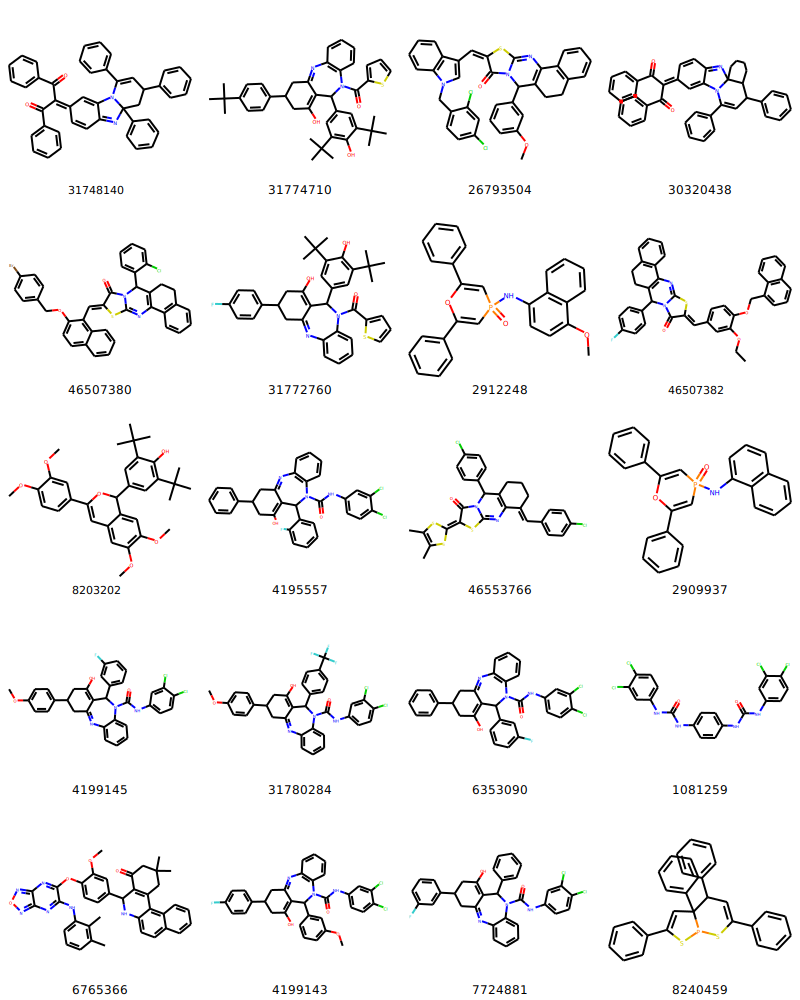

In [76]:
Draw.MolsToGridImage([m[0] for m in bad_mols[:20]], 
                     legends=[m[1] for m in bad_mols[:20]], 
                     molsPerRow=4)

Then we apply the PAINS filters.

In [77]:
new_mols = []
bad_mols = []
for m,idx in comm_mols:
    match = False
    for patt in pains:
        if m.HasSubstructMatch(patt):
            match = True
            break # there is a match, stop searching
    if not match:
        new_mols.append((m, idx))
    else:
        bad_mols.append((m, idx))
comm_mols = new_mols
print "number of molecules without problematic \
substructures = %i" % len(comm_mols) 

number of molecules without problematic substructures = 7392


Let's have a look of some of the discarded molecules at this step:

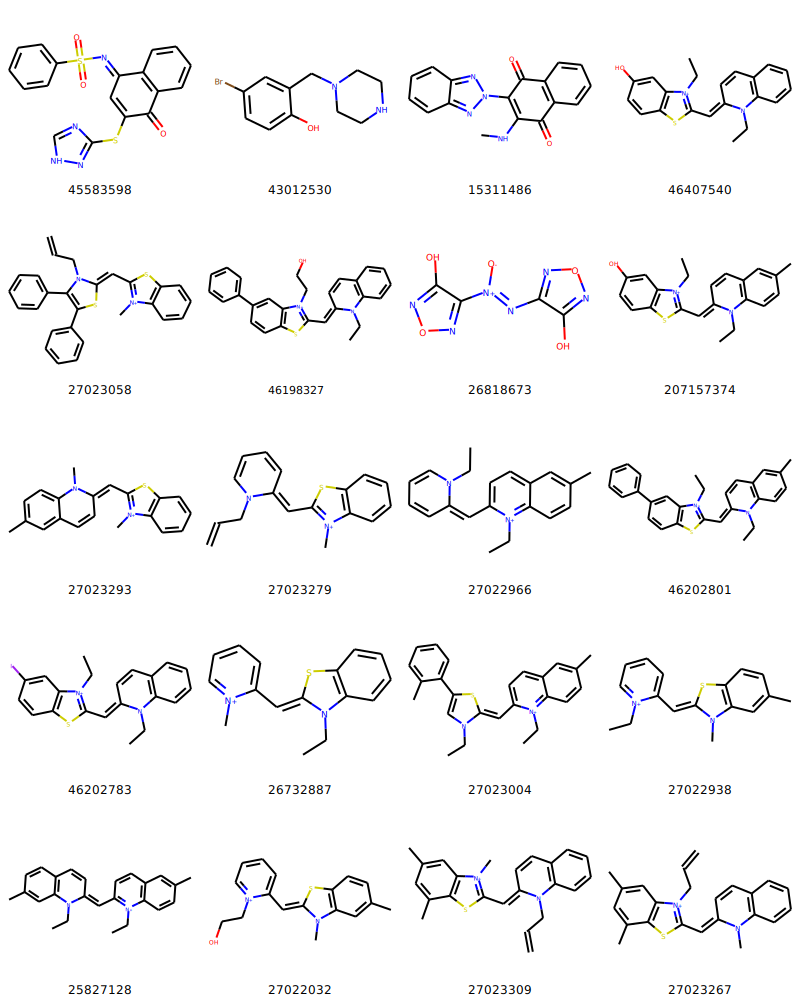

In [78]:
Draw.MolsToGridImage([m[0] for m in bad_mols[:20]], 
                     legends=[m[1] for m in bad_mols[:20]], 
                     molsPerRow=4)

#### Compound Selection

From the remaining compounds, we would like to select 1000 for testing, but we do not want to just take the first 1000 compounds because many of them may share common chemotypes. As in Task 1, we would like to strike a balance between some amount of similar compounds for SAR analysis and as many diverse molecules as possible, but - in contrast to Task 1 - we prefer highly ranked molecules. This time we cannot use the help of the Butina clustering algorithm to group the molecules because the similarity-matrix calculation would require GBs of memory for ~8K molecules. 

Instead we will apply the following procedure: 

* We select the highest-ranked molecule as our first cluster center.
* We take the next lower molecule and calculate the similarity to the first molecule: 
    - If the similarity is below 0.55, we select the molecule as a new cluster center. 
    - If the similarity is above 0.85 and the cluster does not contain 6 molecules yet (including the cluster center), we select the molecule and add it to the cluster.
    - Else we discard it. 
* We continue down the list until we have selected 1000 compounds.

We create our own class to hold the cluster.

In [79]:
class molCluster:
    def __init__(self, mol):
        self.center_fp = Chem.RDKFingerprint(mol[0], maxPath=5)
        self.members = [mol[1]]

The highest-ranked compound is our first cluster center.

In [80]:
comm_clusters = []
comm_clusters.append(molCluster(comm_mols[0]))

Now, we are going down the list until we have selected 1000 molecules.

In [81]:
num_comm_mols = 1000
selected_comm_mols = []
current_index = 1

while len(selected_comm_mols) < num_comm_mols \
and current_index < len(comm_mols):
    m = comm_mols[current_index]
    parent_idx = comm_mols[current_index][1]
    fp = Chem.RDKFingerprint(m[0], maxPath=5)
    
    # loop over clusters
    diverse = True
    for c in comm_clusters:
        # calculate similarity to cluster center
        simil = DataStructs.TanimotoSimilarity(fp, c.center_fp)
        if simil > 0.55:
            diverse = False
            if simil >= 0.85 and len(c.members) < 6: 
                # it belongs to the cluster and there is space, 
                # add identifier
                c.members.append(m[1])
                selected_comm_mols.append(fusion_scores_comm[parent_idx])
            break
            
    # if molecule is different, add a new cluster
    if diverse:
        comm_clusters.append(molCluster(m))
        selected_comm_mols.append(fusion_scores_comm[parent_idx])
        
    current_index += 1
print len(selected_comm_mols)

1000


Let's have a look at the molecules in the first cluster.

In [82]:
comm_mols_dict = {}
for m,idx in comm_mols:
    comm_mols_dict[idx] = m

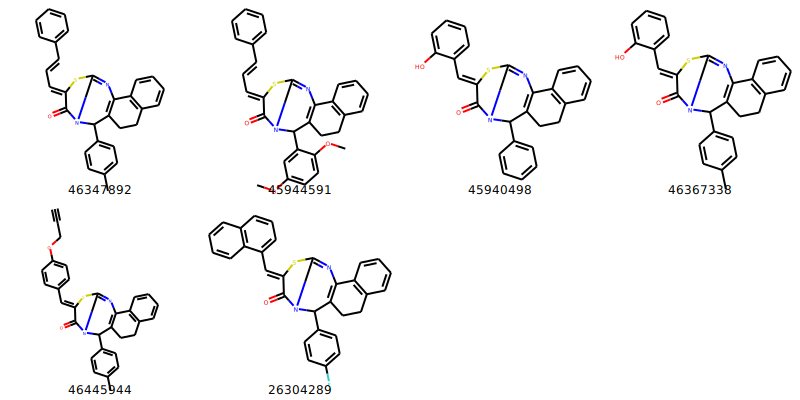

In [83]:
# get scaffold
mcs = MCS.FindMCS([comm_mols_dict[idx] for idx in \
                   comm_clusters[0].members]) 
scaffold = Chem.MolFromSmarts(mcs.smarts)
# generate 2D coordinates for scaffold
AllChem.Compute2DCoords(scaffold)
# align molecules to scaffold
for m in [comm_mols_dict[idx] for idx in comm_clusters[0].members]: 
    AllChem.GenerateDepictionMatching2DStructure(m, scaffold)
    
Draw.MolsToGridImage([comm_mols_dict[idx] for idx in \
                      comm_clusters[0].members], 
                     legends=comm_clusters[0].members, 
                     molsPerRow=4)

With these six molecules, we will be able to learn already something about the SAR as there are several pairs with small structural changes. For example, the first and the second molecule will show the effect of having a methoxy or a methyl groups at one of the phenyl rings.

Now, we write our selection to a file and store it in the directory <i>results</i>.

In [84]:
outfile = open('results/rank_ordered_list_1K_commercial_compounds.txt', 
               'w')
outfile.write("#Identifier\tSMILES\tMax_Rank\tMax_Probability\r\n")
for s in selected_comm_mols:
    # contains: [identifier, SMILES, max rank, max proba, similarity]
    # write: [identifier, SMILES, max rank, max proba]
    outfile.write("%s\r\n" % ("\t".join(s[:4])))
outfile.close()

Testing of these compounds in a Malaria Pf whole-cell assay will tell us if our predictions were right.

## Summary

Congratulations, you finished the tutorial! 

During this tutorial, you learned how to perform ligand-based virtual screening. This involved:

* read molecules, generate molecular 2D fingerprints and calculate fingerprint similarities using the open-source cheminformatics toolkit RDKit
* calculate molecular properties, perform substructure matches and cluster molecules based on similarity using the RDKit
* train different machine-learning (ML) models using the open-source library scikit-learn
* generate similarity maps using the RDKit to understand the predictions made by a ML model
* select good models and combine their strengths by heterogeneous classifier fusion to increase the predictive power

By ranking a large set of commercially available compounds based on the predicted probability of the fusion model, we hope to enrich the number of true actives in the selected 1000 molecules and thus help to find new chemotypes for antimalarial drugs.